IDEAT: KMEANS VIX, Cap max weight for factor

<div style="font-size:14px;">
<strong>TO DO:</strong><br><br>
Tarkistaa ovatko regiimit oikein, exp. antaa ainoana kaikille neg sharpet<br>
Katsoa vielä financial turbulence koodi<br>
Data varmistukset (ei dataa tulevaisuudesta)<br><br>

<strong>Lisää features:</strong><br>
RSI<br>
Yield spread<br>
Muita??<br><br>

<strong>Muuta:</strong><br>
regiimi testaus drawdowneilla?<br><br>
regiimi specifi model ennustus?


<strong>Mallin kehitys:</strong><br>
1. Feature eliminointi<br>
2. Training interval<br>
3. Hyperparametrit
</div>



# GIT & imports

In [167]:
# # GitHub Repository Setup
#
# This cell navigates to `/content`, removes any previous clone of the repository,
# clones the latest version from GitHub, and lists the repository files.

# %%
%cd /content
!rm -rf Gradu
!git clone https://github.com/Elkkujou/Gradu.git
%cd /content/Gradu
!ls


/content
Cloning into 'Gradu'...
remote: Enumerating objects: 458, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 458 (delta 107), reused 79 (delta 79), pack-reused 319 (from 1)
Receiving objects: 100% (458/458), 80.95 MiB | 33.00 MiB/s, done.
Resolving deltas: 100% (217/217), done.
/content/Gradu
 chatti_RF.ipynb		      regime_prediction_msci.ipynb
 data+regimes.xlsx		      regime_pred.txt
 Fama_french_XGBOOST.ipynb	      RF_Gradu.ipynb
'Financial turbulence.ipynb'	     'RF REGIIMI HYVÄ TRAINING.ipynb'
 FT_source.xlsx			     'RF_REGIIMI_HYVÄ_TRAINING (MSCI).ipynb'
 Gradient_boost_malli.ipynb	     'RF_regime (3).ipynb'
 MSCI_XGBOOST.ipynb		      THE_2ND.xlsx
 Regiimi_prediction.ipynb	      THE_ONE.xlsx
 regime_prediction_famafrench.ipynb


In [168]:
skip_training = False
use_regime_split = False
all_combinations =  False


In [169]:
# # Import Required Libraries
#
# Import all necessary libraries for data manipulation, visualization,
# machine learning, and regression analysis.

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate

from IPython.display import display, HTML


In [170]:
# Load and flatten the data

xls_file = pd.ExcelFile("/content/Gradu/THE_2ND.xlsx")
df = xls_file.parse("ajodata")

#xls_file = pd.ExcelFile("/content/Gradu/data+regimes.xlsx")
#df = xls_file.parse("data")

df.columns = df.columns.get_level_values(0)

print("Headers in the '22.2.2025' sheet:")
print(df.columns)

# Features to used as predictive variables

#UNUSED: 'Financial Turbulance'
# 'H.Regimes' // TÄÄÄ RIKKI, EI OO NUMERO

#FEATURES = ['CPI', 'Cape', 'Treasury_10Y', 'NFCI', 'T10YFF', 'DGS1', 'DGS5', 'GARCH', 'Amihud', 'Unemployment_Rate', 'Moody_Baa_Yield', 'Nonfarm_Payrolls']
FEATURES = ['GARCH_1M', 'T10YFF', 'CPI%']


# Model split by column
REGIMES_COLUMN = 'Predicted_reg'

# Used factors
FACTORS = [
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
    'USA MOMENTUM Standard (Large+Mid Cap)',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)',
    'RF'
]


BENCHMARK = [
    'USA Standard (Large+Mid Cap)'
]

# Convert the leftmost column (assumed to be the date column) to datetime
date_column = df.columns[0]
df[date_column] = pd.to_datetime(df[date_column])

# Retrieve first and last observation dates and count observations
first_date = df[date_column].iloc[0]
last_date = df[date_column].iloc[-1]
n_observations = len(df)

# Create a DataFrame with the information
info_df = pd.DataFrame({
    "Description": ["First observation date", "Last observation date", "Total number of observations"],
    "Value": [first_date, last_date, n_observations]
})

# Display the results as a neat HTML table
display(HTML(info_df.to_html(index=False, classes="table table-striped", border=0)))



Headers in the '22.2.2025' sheet:
Index(['Date', 'USA Standard (Large+Mid Cap)',
       'USA MOMENTUM Standard (Large+Mid Cap)',
       'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
       'USA ENHANCED VALUE Standard (Large+Mid Cap)',
       'USA RISK WEIGHTED Standard (Large+Mid Cap)', 'CAPE', 'CAPE%', 'GARCH',
       'T10YFF', 'CPI%', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'MOM',
       'GARCH_1M'],
      dtype='object')


Description,Value
First observation date,1969-12-31 00:00:00
Last observation date,2024-12-31 00:00:00
Total number of observations,661


In [171]:

# --- Define Helper Functions ---
def annualized_return(returns):
    """Compute the compounded annualized return (assuming monthly returns)."""
    return np.prod(1 + returns)**(12 / len(returns)) - 1

def compute_metrics(returns):
    """
    Compute key metrics for a returns series:
      - Annualized Return
      - Annualized Volatility (assuming monthly returns)
      - Total Cumulative Return
    """
    cumulative_returns = (1 + returns).cumprod()
    total_cum_return = cumulative_returns.iloc[-1] - 1
    ann_ret = annualized_return(returns)
    ann_vol = np.std(returns) * np.sqrt(12)
    return ann_ret, ann_vol, total_cum_return

# --- Compute Metrics for Benchmark and Each Factor ---
metrics = []

# Compute metrics for the benchmark.
benchmark_returns = df[BENCHMARK[0]]
bench_ann_ret, bench_ann_vol, bench_cum_return = compute_metrics(benchmark_returns)
metrics.append({
    "Strategy": "Benchmark",
    "Annualized Return": f"{bench_ann_ret*100:.2f}%",
    "Annualized Volatility": f"{bench_ann_vol*100:.2f}%",
    "Total Cumulative Return": f"{bench_cum_return*100:.2f}%"
})

# Compute metrics for each factor in FACTORS.
for factor in FACTORS:
    factor_returns = df[factor]
    factor_ann_ret, factor_ann_vol, factor_cum_return = compute_metrics(factor_returns)
    metrics.append({
        "Strategy": factor,
        "Annualized Return": f"{factor_ann_ret*100:.2f}%",
        "Annualized Volatility": f"{factor_ann_vol*100:.2f}%",
        "Total Cumulative Return": f"{factor_cum_return*100:.2f}%"
    })

# Create a DataFrame from the metrics.
metrics_df = pd.DataFrame(metrics)

# --- Display the Results as an HTML Table ---
display(HTML(metrics_df.to_html(index=False)))





Strategy,Annualized Return,Annualized Volatility,Total Cumulative Return
Benchmark,7.59%,15.34%,5517.20%
USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),8.76%,15.30%,10123.07%
USA MOMENTUM Standard (Large+Mid Cap),10.46%,16.63%,23853.47%
USA ENHANCED VALUE Standard (Large+Mid Cap),7.59%,16.06%,5518.64%
USA RISK WEIGHTED Standard (Large+Mid Cap),8.76%,14.52%,10095.08%
RF,4.44%,0.96%,993.70%


In [172]:
# # Prepare Data for Model Training – Data Cleaning & Verification

# we keep all rows and compute the winning factor as the factor (from FACTORS) with the highest value in each row.

# Print the initial number of rows.
initial_rows = len(df)
print(f"Total number of rows before cleaning: {initial_rows}")

# Check missing values in feature columns (FEATURES) before dropping NAs.
missing_counts = df[FEATURES].isna().sum()
print("\nMissing values in feature columns before dropping NA:")
print(missing_counts)

# Save the number of rows before dropping NA and then drop rows with missing values in FEATURES.
initial_rows_features = len(df)
X = df[FEATURES].dropna()
rows_after_drop = len(X)
dropped_rows = initial_rows_features - rows_after_drop

if dropped_rows > 0:
    print(f"\nDropped {dropped_rows} rows due to missing values in feature columns.")
else:
    print("\nNo missing values found in feature columns. Data is clean.")

# Compute the Winning Factor by taking the column (from FACTORS) that has the maximum value in each row.
# This assumes that the FACTORS columns exist in df and contain numeric values.
df['Winning Factor'] = df[FACTORS].idxmax(axis=1)

# Define the target variable based on rows retained in X.
# The winning factor is encoded as a categorical variable.
y = df['Winning Factor'].astype('category').cat.codes.loc[X.index]
print("\nIndices aligned:", X.index.equals(y.index))

# Ensure the data is sorted by date.
df = df.sort_values('Date').reset_index(drop=True)

# Verify that all required columns exist.
# Here, we require the FEATURES columns, the 'USA Standard (Large+Mid Cap)' column,
# as well as all the FACTORS and the BENCHMARK columns.
required_columns = FEATURES + FACTORS + BENCHMARK
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")
print("\nParameters and dataset verified.")

# Compute the counts for each winning factor.
winning_factor_counts = df['Winning Factor'].value_counts()

# Compute total count and append it as the last row.
total_counts = winning_factor_counts.sum()
winning_factor_counts = pd.concat([winning_factor_counts, pd.Series({'Total': total_counts})])

# Print the counts with "Total" as the last row.
print("\nWinning Factor counts:")
print(winning_factor_counts)


Total number of rows before cleaning: 661

Missing values in feature columns before dropping NA:
GARCH_1M    0
T10YFF      0
CPI%        0
dtype: int64

No missing values found in feature columns. Data is clean.

Indices aligned: True

Parameters and dataset verified.

Winning Factor counts:
RF                                                     245
USA MOMENTUM Standard (Large+Mid Cap)                  181
USA ENHANCED VALUE Standard (Large+Mid Cap)            105
USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)     67
USA RISK WEIGHTED Standard (Large+Mid Cap)              63
Total                                                  661
dtype: int64


In [173]:
# --- Regime Mapping & Conversion to Numeric Codes (Dynamic) ---

# Dynamically extract the unique values in the REGIMES_COLUMN.
unique_regimes = df[REGIMES_COLUMN].unique()

# Convert the Regimes column to a categorical type with the unique values, ordered alphabetically.
df[REGIMES_COLUMN] = pd.Categorical(df[REGIMES_COLUMN], categories=sorted(unique_regimes), ordered=True)

# Create a dictionary mapping numeric codes to the regime names based on the unique values.
regime_mapping = {i: cat for i, cat in enumerate(df[REGIMES_COLUMN].cat.categories)}

# Now encode the Regimes column as numeric codes.
df[REGIMES_COLUMN] = df[REGIMES_COLUMN].cat.codes

# Create a mapping from numeric codes to original regime names.
regime_short_mapping = {code: name for code, name in regime_mapping.items()}

# Calculate the number of observations for each regime using value_counts (without reindexing).
obs_counts = df[REGIMES_COLUMN].value_counts(sort=False)

# Create a DataFrame preview of the regime mapping, including observation counts.
mapping_table_data = []
for code in regime_mapping.keys():
    mapping_table_data.append({
        "Numeric Code": code,
        "Original Name": regime_mapping.get(code, "N/A"),
        "Observations": obs_counts.get(code, 0)
    })

# Append a row with the total observations.
total_obs = obs_counts.sum()
mapping_table_data.append({
    "Numeric Code": "",
    "Original Name": "Total",
    "Observations": total_obs
})

# Create the DataFrame for regime mapping preview and print.
regime_mapping_df = pd.DataFrame(mapping_table_data)

from tabulate import tabulate
print("Preview of Dynamic Regime Mapping:")
print(tabulate(regime_mapping_df, headers="keys", tablefmt="psql", showindex=False))


KeyError: 'Predicted_reg'

In [174]:
# # # Encode Winning Factor & Build Mappings
# #
# # Pre-encode the 'Winning Factor' column and create dictionaries to map full factor names
# # to shorter names and numeric IDs for later reference.
# # A preview of the mapping is printed in a neat table format.

# # %%
# df['Winning Factor Encoded'] = df['Winning Factor'].astype('category').cat.codes
# winning_factor_categories = df['Winning Factor'].astype('category').cat.categories
# winning_factor_mapping = {i: cat for i, cat in enumerate(winning_factor_categories)}

# # Define a mapping for shorter factor names similar to your previous approach.
# factor_rename_mapping = {
#     'USA MOMENTUM Standard (Large+Mid Cap)': 'Momentum',
#     'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)': 'MinVol',
#     'USA RISK WEIGHTED Standard (Large+Mid Cap)': 'RiskWeighted',
#     'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)': 'SectorNeutral',
#     'USA ENHANCED VALUE Standard (Large+Mid Cap)': 'EnhancedValue'
# }

# winning_factor_dict = {
#     full_factor: {
#         'full': full_factor,
#         'short': factor_rename_mapping.get(full_factor, full_factor),
#         'id': i
#     }
#     for i, full_factor in enumerate(winning_factor_categories)
# }

# # Create a small preview of the mapping as a DataFrame.
# mapping_preview = pd.DataFrame([
#     {"ID": d["id"], "Full Name": d["full"], "Short Name": d["short"]}
#     for d in winning_factor_dict.values()
# ])

# from tabulate import tabulate
# print("Preview of Winning Factor Mapping:")
# print(tabulate(mapping_preview, headers="keys", tablefmt="psql", showindex=False))


# Training

### Hyperparameters Table

| Hyperparameter       | Purpose                                   | Common Choices                  |
|----------------------|-------------------------------------------|---------------------------------|
| `n_estimators`      | Number of trees                           | 100 (default), 200, 500         |
| `max_depth`         | Max tree depth                            | `None` (default), 10, 20        |
| `min_samples_split` | Min samples needed to split a node       | 2 (default), 10, 20             |
| `min_samples_leaf`  | Min samples in a leaf                    | 1 (default), 5, 10              |
| `max_features`      | Features per split                       | `'sqrt'` (default), `'log2'`, `None` |
| `bootstrap`         | Use bootstrap sampling                    | `True` (default), `False`       |
| `random_state`      | Set a random seed                         | `None`, 42, 0                   |
| `criterion`         | Splitting method                          | `'gini'` (default), `'entropy'` |
| `oob_score`        | Out-of-bag validation                     | `False` (default), `True`       |
| `n_jobs`           | Parallel training                         | `None`, `-1` (all CPUs)         |


In [175]:
# Identify rows with NA values
rows_with_na = df[df.isna().any(axis=1)]

# Remove rows with NA values
df = df.dropna()

# Print the removed rows
print("Removed rows containing NA values:")
print(rows_with_na)


Removed rows containing NA values:
          Date  USA Standard (Large+Mid Cap)  \
0   1969-12-31                           NaN   
1   1970-01-30                     -0.074080   
2   1970-02-27                      0.053298   
3   1970-03-31                      0.003097   
4   1970-04-30                     -0.089350   
..         ...                           ...   
68  1975-08-29                     -0.024802   
69  1975-09-30                     -0.037969   
70  1975-10-31                      0.065717   
71  1975-11-28                      0.027336   
660 2024-12-31                     -0.026590   

     USA MOMENTUM Standard (Large+Mid Cap)  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
..                                     ...   
68                               -0.015483   
69                  

In [176]:
df

,Date,USA Standard (Large+Mid Cap),USA MOMENTUM Standard (Large+Mid Cap),USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),USA ENHANCED VALUE Standard (Large+Mid Cap),USA RISK WEIGHTED Standard (Large+Mid Cap),CAPE,CAPE%,GARCH,T10YFF,CPI%,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM,GARCH_1M,Winning Factor
72,1975-12-31,-0.012780,-0.007410,-0.020251,-0.004322,-0.008542,10.250368,-0.017774,0.006701,2.96,0.54250,-0.0160,-0.0005,0.0169,-0.0009,0.0057,0.0048,-0.11,0.632733,RF
73,1976-01-30,0.113806,0.124590,0.112500,0.119086,0.136423,11.185051,0.091185,0.008616,2.88,0.35971,0.1216,0.0634,0.0863,-0.0179,0.0228,0.0047,4.45,0.800788,USA RISK WEIGHTED Standard (Large+Mid Cap)
74,1976-02-27,-0.012975,-0.008743,-0.024856,-0.003149,0.007801,11.586093,0.035855,0.007887,2.59,0.17921,0.0032,0.0799,0.0587,-0.0264,0.0387,0.0034,0.38,0.838901,USA RISK WEIGHTED Standard (Large+Mid Cap)
75,1976-03-31,0.032219,0.023194,0.027767,0.030159,0.021761,11.631754,0.003941,0.006845,2.57,0.17889,0.0232,-0.0138,-0.0012,-0.0033,0.0096,0.0040,0.15,0.648460,USA ENHANCED VALUE Standard (Large+Mid Cap)
76,1976-04-30,-0.013146,-0.009299,-0.017928,-0.002576,-0.008776,11.689164,0.004936,0.005272,2.29,0.17857,-0.0149,0.0008,-0.0016,0.0040,-0.0110,0.0042,0.59,0.527921,RF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,2024-07-31,0.011716,-0.021593,0.006805,0.037662,0.047299,35.443553,0.018184,0.010812,-1.42,0.13892,0.0124,0.0828,0.0574,0.0022,0.0043,0.0045,-2.42,1.087011,USA RISK WEIGHTED Standard (Large+Mid Cap)
656,2024-08-30,0.022720,0.028126,0.034011,0.001061,0.031729,34.919631,-0.014782,0.006825,-1.02,0.18019,0.0161,-0.0365,-0.0113,0.0085,0.0086,0.0048,4.79,0.641443,USA SECTOR NEUTRAL QUALITY Standard (Large+Mid...
657,2024-09-30,0.020355,0.030033,0.009996,0.016037,0.016242,35.660184,0.021207,0.004549,-0.55,0.22920,0.0174,-0.0102,-0.0259,0.0004,-0.0026,0.0040,-0.60,0.396629,USA MOMENTUM Standard (Large+Mid Cap)
658,2024-10-31,-0.008114,-0.003074,-0.015896,-0.014963,-0.015492,36.587211,0.025996,0.006847,-0.40,0.22646,-0.0097,-0.0088,0.0089,-0.0138,0.0103,0.0039,2.87,0.684819,RF


In [177]:
import itertools
import os
import pandas as pd
import numpy as np
import time  # Added for timing
from sklearn.ensemble import RandomForestClassifier

# --- PARAMETERS ---
overall_window_size = 120    # Training observations to use
min_obs_train = 0            # Global minimum observations to start predictions
min_obs_regime = 50          # Minimum observations required FOR EACH REGIME

# Assume these are defined in your notebook:
#   - df: your DataFrame with a Date column and other features.
#   - FEATURES: your full list of features (e.g., ['NFCI', 'T10YFF', 'DGS1', 'DGS5', 'CPI', 'Cape', 'Treasury_10Y'])
#   - REGIMES_COLUMN: the column name for regimes.
#   - regime_short_mapping: a dictionary mapping regime codes to names.
#   - FACTORS: list of factor names used for return allocation.
#   - use_regime_split: Boolean flag whether to use regime splitting.

# For testing, we'll use the full FEATURES list for sub-sampling.
features_to_test = FEATURES  # e.g., ['NFCI', 'T10YFF', 'DGS1', 'DGS5', 'CPI', 'Cape', 'Treasury_10Y']

# Generate all combinations of features (subsets of size 3 up to len(features_to_test))
all_feature_combinations = []
for r in range(3, len(features_to_test) + 1):
    all_feature_combinations.extend(list(itertools.combinations(features_to_test, r)))

# Setup output file.
output_filename = "feature_subset_results.csv"
# Remove the file if it exists to start fresh.
if os.path.exists(output_filename):
    os.remove(output_filename)

# Ensure the data is sorted by date.
df_sorted = df.sort_values('Date').reset_index(drop=True)

# Outer loop: iterate over each feature combination.
for comb in all_feature_combinations:
    current_features = list(comb)
    start_time = time.time()  # Start timer for this combination
    print(f"\nTesting feature combination: {current_features}")

    # Container for results for this specific feature subset.
    results = []

    # Rolling window loop: iterate over each test row.
    for i in range(overall_window_size, len(df_sorted)):
        test_row = df_sorted.iloc[i]
        Predicted_month = test_row['Date']

        # If regime splitting is active, check that all regimes have enough observations.
        if use_regime_split:
            data_up_to_now = df_sorted.iloc[:i]
            regime_counts = data_up_to_now[REGIMES_COLUMN].value_counts()
            insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
            if insufficient_regimes:
                continue

        # Build the training window.
        if use_regime_split:
            current_regime = test_row[REGIMES_COLUMN]
            train_rows = []
            j = i - 1
            while j >= 0 and len(train_rows) < overall_window_size:
                candidate = df_sorted.iloc[j]
                if candidate[REGIMES_COLUMN] == current_regime:
                    train_rows.append(candidate)
                j -= 1
            if len(train_rows) < min_obs_regime:
                continue
            train_window = pd.DataFrame(train_rows[::-1])
        else:
            train_window = df_sorted.iloc[i - overall_window_size: i].copy()
            if len(train_window) < min_obs_train:
                continue

        # Ensure the last training observation is from a strictly earlier month.
        last_train_date = train_window['Date'].iloc[-1]
        if last_train_date.year == Predicted_month.year and last_train_date.month >= Predicted_month.month:
            continue

        # Prepare training data using the current feature subset.
        X_train = train_window[current_features].dropna()
        y_train = train_window['Winning Factor'].loc[X_train.index]
        if len(X_train) < min_obs_train:
            continue

        # Train the Random Forest model.
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)

        # Compute tree depth statistics (for logging).
        tree_depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]
        avg_depth = np.mean(tree_depths)
        max_depth = np.max(tree_depths)

        # Prepare test data using the same feature subset.
        X_test = test_row[current_features].to_frame().T.dropna()
        if X_test.empty:
            continue

        # Predict probabilities and winning factor.
        predicted_probabilities = rf_model.predict_proba(X_test)[0]
        predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

        # Allocate return by weighting each factor's return by its predicted probability.
        full_probs = np.zeros(len(FACTORS))
        for cls, prob in zip(rf_model.classes_, predicted_probabilities):
            try:
                idx = FACTORS.index(cls)
                full_probs[idx] = prob
            except ValueError:
                print(f"Warning: Class '{cls}' not found in FACTORS.")
        allocated_return = (full_probs * test_row[FACTORS].values).sum()

        # Determine the regime used (if applicable).
        if use_regime_split:
            regime_used = regime_short_mapping.get(test_row[REGIMES_COLUMN], str(test_row[REGIMES_COLUMN]))
        else:
            regime_used = 'NoRegime'

        # Compute the average feature importance for this model.
        avg_feature_importance = np.mean(rf_model.feature_importances_)

        # Store the result for this test row.
        result = {
            'Features_used': str(current_features),
            'Regime': regime_used,
            'Predicted_month': Predicted_month,
            'Allocated_Return': allocated_return,
            'Feature_Importances': rf_model.feature_importances_,
            'Average_Feature_Importance': avg_feature_importance,
            'Predicted_Winner': predicted_winner,
            'Actual_Winner': test_row['Winning Factor'],
            'Num_Trees': rf_model.n_estimators,
            'Average_Tree_Depth': avg_depth,
            'Max_Tree_Depth': max_depth
        }
        results.append(result)

    # If there are any results for this feature combination, save them to CSV.
    if results:
        df_results_comb = pd.DataFrame(results)
        # Append to CSV; if the file doesn't exist, include the header.
        if not os.path.exists(output_filename):
            df_results_comb.to_csv(output_filename, mode='a', header=True, index=False)
        else:
            df_results_comb.to_csv(output_filename, mode='a', header=False, index=False)
        elapsed_time = time.time() - start_time  # Calculate elapsed time
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)
        print(f"Results for combination {current_features} appended to CSV. Time taken: {minutes:02d}:{seconds:02d}")


Testing feature combination: ['GARCH_1M', 'T10YFF', 'CPI%']


KeyboardInterrupt: 

In [179]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Parameters
overall_window_size = 120    # Training observations to use
min_obs_train = 0           # Global min observations to start predictions
min_obs_regime = 50         # Min observations required FOR EACH REGIME

results = []
df_sorted = df.sort_values('Date').reset_index(drop=True)

for i in range(overall_window_size, len(df_sorted)):
    test_row = df_sorted.iloc[i]
    Predicted_month = test_row['Date']
    skip_iteration = False  # Flag to control flow

    # Global regime check (applies when regime splitting is active)
    if use_regime_split:
        data_up_to_now = df_sorted.iloc[:i]
        regime_counts = data_up_to_now[REGIMES_COLUMN].value_counts()
        insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
        if insufficient_regimes:
            regime_str_list = [regime_short_mapping.get(r, str(r)) for r in insufficient_regimes]
            regime_str = ", ".join(regime_str_list)
            print(f"Test row date: {Predicted_month.date()}")
            print(f"  🔴 Regime split active. Insufficient data in: {regime_str} (<{min_obs_regime} obs). Skipping.\n")
            continue

    if use_regime_split:
        current_regime = test_row[REGIMES_COLUMN]
        train_rows = []
        j = i - 1
        while j >= 0 and len(train_rows) < overall_window_size:
            candidate = df_sorted.iloc[j]
            if candidate[REGIMES_COLUMN] == current_regime:
                train_rows.append(candidate)
            j -= 1
        if len(train_rows) < min_obs_regime:
            regime_str = regime_short_mapping.get(current_regime, str(current_regime))
            print(f"Test row date: {Predicted_month.date()}")
            print(f"  🔴 Regime split active ({regime_str}). Only {len(train_rows)} obs. Skipping.\n")
            continue
        train_window = pd.DataFrame(train_rows[::-1])
        train_start_date = train_window['Date'].iloc[0]
        train_end_date = train_window['Date'].iloc[-1]
        regime_str = regime_short_mapping.get(current_regime, str(current_regime))
        print(f"Test row date: {Predicted_month.date()}")
        print(f"  🟢 Regime split active ({regime_str}). Training window: {train_start_date.date()} to {train_end_date.date()}, {len(train_window)} obs")
    else:
        train_window = df_sorted.iloc[i - overall_window_size : i].copy()
        if len(train_window) < min_obs_train:
            print(f"Test row date {Predicted_month.date()}: Insufficient training data ({len(train_window)} < {min_obs_train}). Skipping.\n")
            continue
        train_start_date = train_window['Date'].iloc[0]
        train_end_date = train_window['Date'].iloc[-1]
        print(f"Test row date: {Predicted_month.date()}")
        print(f"  No regime split. Training window: {train_start_date.date()} to {train_end_date.date()}, {len(train_window)} obs")

    last_train_date = train_window['Date'].iloc[-1]
    if last_train_date.year == Predicted_month.year and last_train_date.month >= Predicted_month.month:
        print(f"Test row {Predicted_month.date()}: Last training date in same month. Skipping.\n")
        continue

    X_train = train_window[FEATURES].dropna()
    y_train = train_window['Winning Factor'].loc[X_train.index]
    if len(X_train) < min_obs_train:
        print(f"   -> After dropping NAs: Insufficient data ({len(X_train)} < {min_obs_train}). Skipping.\n")
        continue

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    tree_depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]
    avg_depth = np.mean(tree_depths)
    max_depth = np.max(tree_depths)

    print(f"   -> Model trained with {rf_model.n_estimators} trees; average depth: {avg_depth:.2f}, max depth: {max_depth}")

    X_test = test_row[FEATURES].to_frame().T.dropna()
    if X_test.empty:
        print("   -> Test features are empty, skipping iteration.\n")
        continue

    predicted_probabilities = rf_model.predict_proba(X_test)[0]
    predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

    full_probs = np.zeros(len(FACTORS))
    for cls, prob in zip(rf_model.classes_, predicted_probabilities):
        try:
            idx = FACTORS.index(cls)
            full_probs[idx] = prob
        except ValueError:
            print(f"Warning: Class '{cls}' not found in FACTORS.")
    allocated_return = (full_probs * test_row[FACTORS].values).sum()

    regime_used = regime_short_mapping.get(test_row[REGIMES_COLUMN], str(test_row[REGIMES_COLUMN])) if use_regime_split else 'NoRegime'

    result = {
        'Regime': regime_used,
        'Predicted_month': Predicted_month,
        'Train_Start_Date': train_start_date,
        'Train_End_Date': train_end_date,
        'Train_Count': len(X_train),
        'Feature_Importances': rf_model.feature_importances_,
        'Predicted_Probabilities': full_probs,
        'Predicted_Winner': predicted_winner,
        'Allocated_Return': allocated_return,
        'Actual_Winner': test_row['Winning Factor'],
        'Num_Trees': rf_model.n_estimators,
        'Average_Tree_Depth': avg_depth,
        'Max_Tree_Depth': max_depth
    }
    results.append(result)

    print("   -> Model trained and prediction made.\n")

results_df = pd.DataFrame(results)
print("Headers in results_df:")
print(results_df.columns.tolist())
html_table = results_df.head(200).to_html(index=False)
display(HTML(html_table))

Test row date: 1985-12-31
  No regime split. Training window: 1975-12-31 to 1985-11-29, 120 obs
   -> Model trained with 100 trees; average depth: 12.38, max depth: 18
   -> Model trained and prediction made.

Test row date: 1986-01-31
  No regime split. Training window: 1976-01-30 to 1985-12-31, 120 obs
   -> Model trained with 100 trees; average depth: 12.18, max depth: 16
   -> Model trained and prediction made.

Test row date: 1986-02-28
  No regime split. Training window: 1976-02-27 to 1986-01-31, 120 obs
   -> Model trained with 100 trees; average depth: 12.02, max depth: 19
   -> Model trained and prediction made.

Test row date: 1986-03-31
  No regime split. Training window: 1976-03-31 to 1986-02-28, 120 obs
   -> Model trained with 100 trees; average depth: 12.53, max depth: 18
   -> Model trained and prediction made.

Test row date: 1986-04-30
  No regime split. Training window: 1976-04-30 to 1986-03-31, 120 obs
   -> Model trained with 100 trees; average depth: 12.32, max de

Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Actual_Winner,Num_Trees,Average_Tree_Depth,Max_Tree_Depth
NoRegime,1985-12-31,1975-12-31,1985-11-29,120,"[0.3354985341759915, 0.3376606598832336, 0.3268408059407749]","[0.13, 0.11, 0.05, 0.17, 0.54]",RF,0.024464,USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),100,12.38,18
NoRegime,1986-01-31,1976-01-30,1985-12-31,120,"[0.3281617374776337, 0.34307855457720854, 0.3287597079451576]","[0.04, 0.54, 0.09, 0.07, 0.26]",USA MOMENTUM Standard (Large+Mid Cap),0.013907,USA MOMENTUM Standard (Large+Mid Cap),100,12.18,16
NoRegime,1986-02-28,1976-02-27,1986-01-31,120,"[0.32983743364172113, 0.3378319172413886, 0.3323306491168902]","[0.1, 0.19, 0.11, 0.2, 0.4]",RF,0.049891,USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),100,12.02,19
NoRegime,1986-03-31,1976-03-31,1986-02-28,120,"[0.32677583510719416, 0.3420653008443907, 0.33115886404841527]","[0.48, 0.24, 0.16, 0.04, 0.08]",USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),0.068504,USA MOMENTUM Standard (Large+Mid Cap),100,12.53,18
NoRegime,1986-04-30,1976-04-30,1986-03-31,120,"[0.32415670092256477, 0.34472033011035635, 0.3311229689670788]","[0.49, 0.27, 0.18, 0.04, 0.02]",USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),-0.015885,RF,100,12.32,19
NoRegime,1986-05-30,1976-05-31,1986-04-30,120,"[0.33049601327537076, 0.3439768875311971, 0.32552709919343215]","[0.09, 0.37, 0.21, 0.06, 0.27]",USA MOMENTUM Standard (Large+Mid Cap),0.043533,USA MOMENTUM Standard (Large+Mid Cap),100,12.27,18
NoRegime,1986-06-30,1976-06-30,1986-05-30,120,"[0.3273213889612763, 0.34629967155059443, 0.32637893948812924]","[0.34, 0.18, 0.0, 0.13, 0.35]",RF,0.022692,USA MOMENTUM Standard (Large+Mid Cap),100,12.14,18
NoRegime,1986-07-31,1976-07-30,1986-06-30,120,"[0.33023809143630295, 0.3414890261805089, 0.32827288238318814]","[0.16, 0.39, 0.05, 0.01, 0.39]",RF,-0.031191,RF,100,11.97,17
NoRegime,1986-08-29,1976-08-31,1986-07-31,120,"[0.3342136899804512, 0.33779647645114574, 0.3279898335684031]","[0.22, 0.59, 0.01, 0.06, 0.12]",USA MOMENTUM Standard (Large+Mid Cap),0.038952,USA ENHANCED VALUE Standard (Large+Mid Cap),100,12.26,18
NoRegime,1986-09-30,1976-09-30,1986-08-29,120,"[0.3258306692483441, 0.3487768186302451, 0.32539251212141085]","[0.1, 0.21, 0.24, 0.16, 0.29]",RF,-0.067514,RF,100,12.58,22


In [180]:
import pandas as pd
from IPython.display import display

# ----- User-Defined Date Range -----
start_date_user = pd.to_datetime('1985-12-31')  # example start date
end_date_user   = pd.to_datetime('2020-12-31')  # example end date

# 1) Filter your results_df by the user-defined date range
filtered_results = results_df[
    (results_df['Predicted_month'] >= start_date_user) &
    (results_df['Predicted_month'] <= end_date_user)
].copy()

# 2) Merge with original data (df_sorted) to get factor returns and features
merged_display = pd.merge(
    filtered_results,
    df_sorted,
    left_on='Predicted_month',
    right_on='Date',
    suffixes=('_pred', '_orig')
)

# 3) Round the feature importances to (say) 3 decimal places
merged_display['Feature_Importances'] = merged_display['Feature_Importances'].apply(
    lambda arr: [round(val, 3) for val in arr]
)

# 4) Select columns to display
cols_to_display = (
    ['Predicted_month', 'Predicted_Probabilities', 'Feature_Importances', 'Allocated_Return']
    + FEATURES
    + FACTORS
)

display_df = merged_display[cols_to_display].copy()

# 5) Rename 'Allocated_Return' for clarity
display_df.rename(columns={'Allocated_Return': 'ML Allocated Return'}, inplace=True)

# 6) Compute the highest factor return and the difference
display_df['Highest Factor Return'] = display_df[FACTORS].max(axis=1)
display_df['Diff Allocated vs Highest Factor'] = (
    display_df['ML Allocated Return'] - display_df['Highest Factor Return']
)

# 7) Display the final table
print("ML Allocated Return, Single-Column Feature Importances & Predicted Probabilities, Features, and Factor Returns:")
display(display_df)

ML Allocated Return, Single-Column Feature Importances & Predicted Probabilities, Features, and Factor Returns:


,Predicted_month,Predicted_Probabilities,Feature_Importances,ML Allocated Return,GARCH_1M,T10YFF,CPI%,USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),USA MOMENTUM Standard (Large+Mid Cap),USA ENHANCED VALUE Standard (Large+Mid Cap),USA RISK WEIGHTED Standard (Large+Mid Cap),RF,Highest Factor Return,Diff Allocated vs Highest Factor
0,1985-12-31,"[0.13, 0.11, 0.05, 0.17, 0.54]","[0.335, 0.338, 0.327]",0.024464,0.573788,0.99,0.45872,0.050697,0.036305,0.045985,0.047476,0.0065,0.050697,-0.026232
1,1986-01-31,"[0.04, 0.54, 0.09, 0.07, 0.26]","[0.328, 0.343, 0.329]",0.013907,0.784378,0.18,0.36530,0.002578,0.020757,0.000925,0.015091,0.0056,0.020757,-0.006849
2,1986-02-28,"[0.1, 0.19, 0.11, 0.2, 0.4]","[0.33, 0.338, 0.332]",0.049891,0.418969,-0.67,-0.18198,0.084126,0.083584,0.072036,0.077768,0.0053,0.084126,-0.034235
3,1986-03-31,"[0.48, 0.24, 0.16, 0.04, 0.08]","[0.327, 0.342, 0.331]",0.068504,0.623650,0.33,-0.54695,0.078153,0.084300,0.050047,0.056763,0.0060,0.084300,-0.015796
4,1986-04-30,"[0.49, 0.27, 0.18, 0.04, 0.02]","[0.324, 0.345, 0.331]",-0.015885,0.879752,1.21,-0.36664,-0.010157,-0.020091,-0.024119,-0.031139,0.0052,0.005200,-0.021085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,2020-08-31,"[0.49, 0.18, 0.17, 0.16, 0.0]","[0.369, 0.325, 0.306]",0.062649,0.484220,0.60,0.37313,0.068127,0.095518,0.036208,0.036991,0.0001,0.095518,-0.032868
417,2020-09-30,"[0.03, 0.34, 0.06, 0.02, 0.55]","[0.356, 0.326, 0.318]",-0.016064,1.216091,0.79,0.26261,-0.032705,-0.039318,-0.022115,-0.022159,0.0001,0.000100,-0.016164
418,2020-10-30,"[0.02, 0.35, 0.08, 0.03, 0.52]","[0.36, 0.322, 0.318]",-0.016718,1.290117,0.75,0.12385,-0.028550,-0.042177,-0.014128,-0.010209,0.0001,0.000100,-0.016818
419,2020-11-30,"[0.1, 0.55, 0.05, 0.04, 0.26]","[0.367, 0.323, 0.31]",0.080185,0.799844,0.84,0.22741,0.112552,0.102131,0.161035,0.117010,0.0001,0.161035,-0.080850


In [151]:
# Optional: Expand the feature importances array into separate columns (only if not done already).
if not feature_importances_expanded:
    print("Expanding feature importances into separate columns...")
    for idx, feature in enumerate(FEATURES):
        results_df[f'FI_{feature}'] = results_df['Feature_Importances'].apply(lambda x: x[idx] if isinstance(x, np.ndarray) else np.nan)
        print(f"  Added column for feature importance: FI_{feature}")
    feature_importances_expanded = True  # Set the flag to True

# Optional: Expand predicted probabilities into separate columns (only if not done already).
if not results_df.empty and isinstance(results_df['Predicted_Probabilities'].iloc[0], np.ndarray) and not probabilities_expanded:
    num_probs = results_df['Predicted_Probabilities'].iloc[0].shape[0]
    print(f"Expanding predicted probabilities into {num_probs} separate columns...")

    for j in range(num_probs):
        # Assign the probability value to the new column 'Prob_{j}'
        results_df[f'Prob_{j}'] = results_df['Predicted_Probabilities'].apply(lambda x: x[j] if isinstance(x, np.ndarray) else np.nan)
        print(f"  Added column for predicted probability: Prob_{j}")

        # Rename the probability columns using the short factor names with '_prob' suffix
        factor_shortname_prob = factor_rename_mapping.get(FACTORS[j], FACTORS[j])  # Get short name
        results_df = results_df.rename(columns={f'Prob_{j}': f'{factor_shortname_prob}_prob'})  # Add '_prob' suffix
        print(f"  Renamed column 'Prob_{j}' to '{factor_shortname_prob}_prob'")
    probabilities_expanded = True  # Set the flag to True

# At the end of the loop, convert numeric regime codes back to their string names (only if not done already).
if not regimes_converted:
    print("Converting numeric regime codes back to their string names...")
    results_df['Regime'] = results_df['Regime'].apply(lambda x: regime_short_mapping.get(x, str(x)))
    print("  Regimes converted.")
    regimes_converted = True  # Set the flag to True

# Optional: You can also map the 'Predicted_Winner' back to its string name if it's encoded numerically (only if not done already).
if not predicted_winner_converted:
    print("Converting 'Predicted_Winner' from numeric codes to string names...")
    results_df['Predicted_Winner'] = results_df['Predicted_Winner'].apply(lambda x: regime_short_mapping.get(x, str(x)))
    print("  'Predicted_Winner' converted.")
    predicted_winner_converted = True  # Set the flag to True

# Display the first row as an HTML table
html_table = results_df.iloc[0:5].to_html(index=False)  # Select the first row
display(HTML(html_table))


NameError: name 'feature_importances_expanded' is not defined

In [121]:

# Calculate the ending row. If it exceeds the number of rows in results_df, it will be set to the maximum.
end_row = start_row + num_rows_to_show
if end_row > len(results_df):
    end_row = len(results_df)

# Parameters
start_row = 0         # Change this to your desired starting row index.
num_rows_to_show = 50  # Change this to the number of rows you want to display.

# Calculate the ending row. If it exceeds the number of rows in results_df, it will be set to the maximum.
end_row = start_row + num_rows_to_show
if end_row > len(results_df):
    end_row = len(results_df)


# Create the 'Correct' column by comparing Predicted_Winner with Actual_Winner
results_df['Correct'] = results_df['Predicted_Winner'] == results_df['Actual_Winner']

# Identify the probability columns (e.g., Momentum_prob, MinVol_prob, etc.)
prob_cols = [col for col in results_df.columns if col.endswith('_prob')]

# Calculate 'Max_Probability' by taking the max of the probability columns
results_df['Max_Probability'] = results_df[prob_cols].max(axis=1)

# Select the required columns to display in the table
columns_to_display = [
    'Predicted_month', 'Regime', 'Correct', 'Predicted_Winner', 'Actual_Winner',
    'Allocated_Return', 'Max_Probability'
]

# Add the probability columns to the display list (to show them at the right side)
columns_to_display += prob_cols

# Filter the DataFrame to only include the required columns
table_data = results_df[columns_to_display].iloc[start_row:end_row]

# Convert 'Correct' column to boolean (True/False)
table_data['Correct'] = table_data['Correct'].apply(lambda x: 'True' if x else 'False')

# Generate a pretty HTML table using pandas' built-in functionality
html_table = table_data.to_html(index=False, escape=False)

# Display the HTML table
from IPython.display import HTML, display
display(HTML(html_table))






NameError: name 'start_row' is not defined

In [122]:
from sklearn.metrics import accuracy_score
from IPython.display import display, HTML
import numpy as np

# Calculate total test months considered.
# The loop started at overall_window_size and went to the end of df_sorted.
total_test_months = len(df_sorted) - overall_window_size
predicted_months = len(results_df)
skipped_months = total_test_months - predicted_months

# Check if the 'Actual_Winner' column exists.
if 'Actual_Winner' not in results_df.columns:
    print("Error: 'Actual_Winner' column not found in results_df. Please ensure that the true winning factor is saved as 'Actual_Winner'.")
else:
    # Compute the combined (weighted) accuracy over all predictions.
    combined_accuracy = accuracy_score(results_df['Actual_Winner'], results_df['Predicted_Winner'])
    total_predictions = len(results_df)
    correct_predictions = sum(results_df['Actual_Winner'] == results_df['Predicted_Winner'])

    # Assuming there are 'n' classes, random accuracy = 1/n.
    n_classes = len(winning_factor_mapping)
    expected_accuracy = 1 / n_classes
    excess_accuracy = combined_accuracy - expected_accuracy

    # Compute accuracy for each regime without triggering the deprecation warning.
    # Loop through each regime group, converting the numeric regime code back to its short name.
    accuracy_by_regime = {}
    counts_by_regime = {}
    correct_by_regime = {}
    for regime, group in results_df.groupby('Regime'):
        acc = accuracy_score(group['Actual_Winner'], group['Predicted_Winner'])
        count = len(group)
        correct_count = sum(group['Actual_Winner'] == group['Predicted_Winner'])
        regime_name = regime_short_mapping.get(regime, str(regime))
        accuracy_by_regime[regime_name] = acc
        counts_by_regime[regime_name] = count
        correct_by_regime[regime_name] = correct_count

    # Build an HTML string to display the results.
    html_str = f"""
    <br>
    <div style='font-size:24px; text-align:center; margin:20px 0;'>
      <strong>Prediction Summary:</strong><br>
      Total months considered for prediction: {total_test_months}<br>
      Months predicted: {predicted_months}<br>
      Months without prediction: {skipped_months}<br><br>
      <strong>Combined Accuracy:</strong> {combined_accuracy:.2%}
      ({correct_predictions} correct out of {total_predictions} predictions)<br><br>
      <strong>Expected Accuracy (random guess):</strong> {expected_accuracy:.2%}<br><br>
      <strong>Excess Accuracy:</strong> {excess_accuracy:.2%}<br><br>
    """
    for regime_name, acc in accuracy_by_regime.items():
        count = counts_by_regime[regime_name]
        correct_count = correct_by_regime[regime_name]
        html_str += f"<strong>Accuracy for Regime {regime_name} (n={count}):</strong> {acc:.2%} ({correct_count} correct out of {count} predictions)<br>"
    html_str += "</div><br>"

    display(HTML(html_str))


NameError: name 'winning_factor_mapping' is not defined

In [123]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get all unique regimes dynamically
all_regimes = results_df['Regime'].unique()

# Prepare labels from winning factors (sorted by their numeric IDs)
labels = [winning_factor_dict[winning_factor_mapping[i]]['short']
          for i in sorted(winning_factor_mapping.keys())]

# Convert to short names for actual/predicted values
all_true = results_df['Actual_Winner'].map(lambda x: factor_rename_mapping.get(x, x))
all_pred = results_df['Predicted_Winner'].map(lambda x: factor_rename_mapping.get(x, x))

# Create a figure with a grid layout for the confusion matrices
# Increase the figsize width by 30% (from 15 to 19.5)
fig, axes = plt.subplots(nrows=1, ncols=len(all_regimes) + 1, figsize=(19.5, 8))

# 1. Overall confusion matrix
cm_total = confusion_matrix(all_true, all_pred, labels=labels)
sns.heatmap(cm_total, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels,
            ax=axes[0])
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

# Calculate the number of samples for the overall matrix
total_samples = len(results_df)
axes[0].set_title(f"Overall Confusion Matrix (All Regimes)\n({total_samples} samples)")

# 2. Per-regime confusion matrices
for i, regime in enumerate(all_regimes):
    # Filter results for current regime
    regime_mask = results_df['Regime'] == regime
    regime_true = all_true[regime_mask]
    regime_pred = all_pred[regime_mask]

    if len(regime_true) == 0:
        print(f"\nNo samples for regime '{regime}'. Skipping confusion matrix.")
        continue

    # Plot the confusion matrix for the regime
    cm = confusion_matrix(regime_true, regime_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels,
                ax=axes[i+1])  # i+1 to place the regime-specific matrix
    axes[i+1].set_xlabel("Predicted Labels")
    axes[i+1].set_ylabel("True Labels")
    axes[i+1].set_title(f"{regime} Regime\n({len(regime_true)} samples)")

# Adjust layout to make space between the subplots
plt.tight_layout(pad=4.0)  # pad=4.0 adds space between subplots

# Adjust the spacing between subplots if needed
plt.subplots_adjust(wspace=0.3)  # Add space between subplots

# Show the plot
plt.show()



NameError: name 'winning_factor_mapping' is not defined

<ipython-input-181-d99f00845294>:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=4.0)


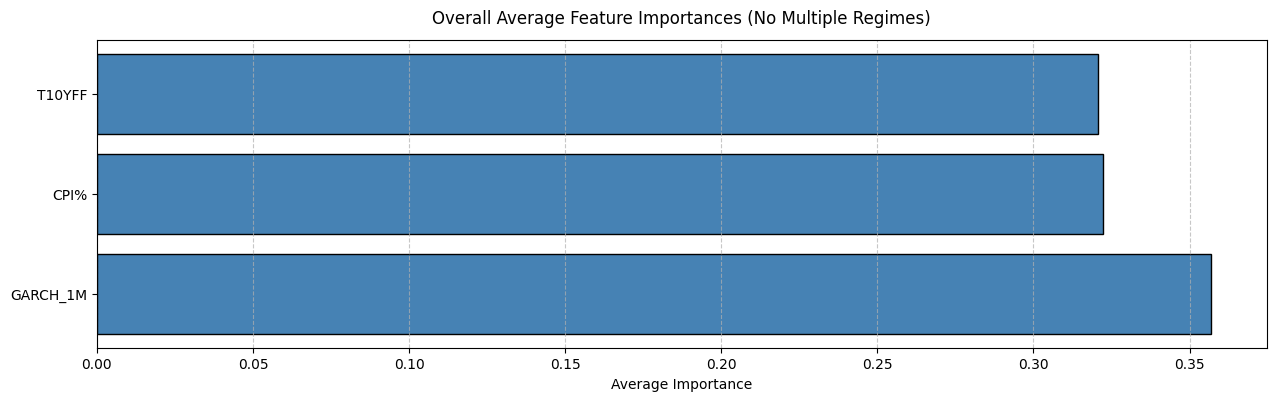

In [181]:
# --- Code cell 26 ---
# 2. Regime-Specific Feature Importances (Dynamic Version)
# ========================================================

import numpy as np
import matplotlib.pyplot as plt

# Get the unique regimes from results_df (already converted to string names)
existing_regimes = results_df['Regime'].unique()
n_regimes = len(existing_regimes)

# Dynamically get the number of features from the data
n_features = len(results_df['Feature_Importances'].iloc[0])  # Actual feature count

# Robust feature name handling:
try:
    # Validate FEATURES list length matches actual features
    if len(FEATURES) != n_features:
        print(f"⚠️ Warning: FEATURES list length ({len(FEATURES)}) doesn't match model features ({n_features})")
        print("Using auto-generated feature names instead")
        raise ValueError
    feature_names = FEATURES
except (NameError, ValueError):
    # Generate descriptive feature names if there's a mismatch or error
    feature_names = [f'Feature {i+1}' for i in range(n_features)]
    print(f"Using auto-generated feature names for {n_features} features")

# Compute overall average feature importances across all predictions
overall_avg_fi = np.vstack(results_df['Feature_Importances'].values).mean(axis=0)

# Calculate regime-specific average feature importances
regime_avg_fi = {}
for regime_name in existing_regimes:
    regime_df = results_df[results_df['Regime'] == regime_name]
    regime_fi_array = np.vstack(regime_df['Feature_Importances'].values)
    regime_avg_fi[regime_name] = regime_fi_array.mean(axis=0)

# Sort features by overall importance in descending order
sorted_idx = overall_avg_fi.argsort()[::-1]
sorted_idx = sorted_idx[sorted_idx < len(feature_names)]  # bounds check
sorted_features = [feature_names[i] for i in sorted_idx]

# 1) If we have more than one unique regime, make an overall + multiple regime subplots
if n_regimes > 1:
    total_plots = 1 + n_regimes  # One for overall, one per regime
    # Figure height depends on number of plots and number of features
    row_height = max(0.3 * n_features, 4)
    fig, axs = plt.subplots(
        total_plots,
        1,
        figsize=(19.5, total_plots * row_height),
        gridspec_kw={'hspace': 0.4}
    )
    if total_plots == 1:
        axs = [axs]  # ensure iterable

    # --- Overall Feature Importances ---
    axs[0].barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    axs[0].set_yticks(np.arange(n_features))
    axs[0].set_yticklabels(sorted_features)
    axs[0].set_title("Overall Average Feature Importances", pad=12)
    axs[0].set_xlabel("Average Importance")
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)

    # --- Regime-Specific Plots ---
    for idx, (regime_name, avg_fi) in enumerate(regime_avg_fi.items(), start=1):
        sorted_regime_fi = avg_fi[sorted_idx]
        axs[idx].barh(
            np.arange(n_features),
            sorted_regime_fi,
            color='salmon',
            edgecolor='black'
        )
        axs[idx].set_yticks(np.arange(n_features))
        axs[idx].set_yticklabels(sorted_features)
        axs[idx].set_title(f"Feature Importances: {regime_name} Regime", pad=12)
        axs[idx].set_xlabel("Average Importance")
        axs[idx].grid(axis='x', linestyle='--', alpha=0.7)

# 2) Otherwise, if there's only zero or one regime, show only the overall chart
else:
    total_plots = 1
    row_height = max(0.3 * n_features, 4)
    fig, ax = plt.subplots(
        1, 1, figsize=(19.5, row_height),
        gridspec_kw={'hspace': 0.4}
    )

    # --- Overall Feature Importances ---
    ax.barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels(sorted_features)
    ax.set_title("Overall Average Feature Importances (No Multiple Regimes)", pad=12)
    ax.set_xlabel("Average Importance")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.3)  # Provide extra space on the left for feature labels
plt.show()


Date Range: 1985-12-31 00:00:00 to 2024-11-29 00:00:00


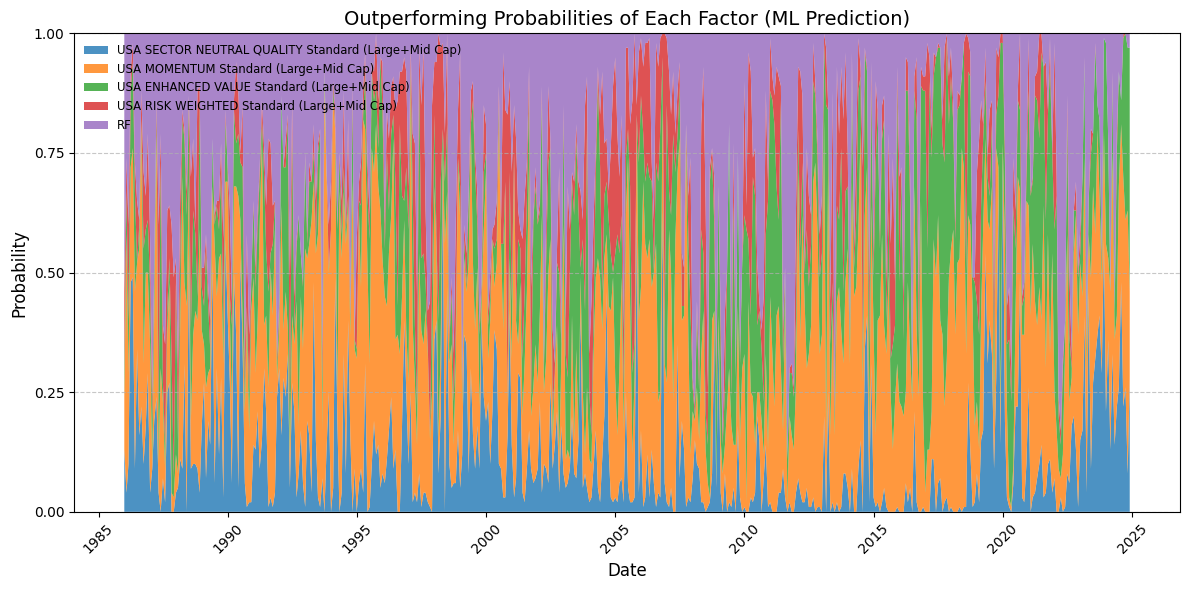

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Convert "Predicted_month" to datetime (assuming the format is '%Y-%m'):
probability_dates = pd.to_datetime(
    results_df["Predicted_month"],
    format='%Y-%m'
)

# 2) Drop rows with unparseable dates if needed
if probability_dates.isna().any():
    print("Warning: Some dates could not be parsed. Dropping those rows.")
    results_df = results_df.loc[~probability_dates.isna()].copy()
    probability_dates = probability_dates.dropna()

# 3) Extract the probability arrays and build a DataFrame
full_probs = np.vstack(results_df["Predicted_Probabilities"].values)
probability_df = pd.DataFrame(full_probs, columns=FACTORS)
probability_df["Date"] = probability_dates
probability_df = probability_df.sort_values("Date").reset_index(drop=True)

# 4) Check date range
print("Date Range:", probability_df["Date"].min(), "to", probability_df["Date"].max())

# 5) Plot the probabilities in a stack plot
plt.figure(figsize=(12, 6))
plt.stackplot(
    probability_df["Date"],
    [probability_df[col] for col in FACTORS],
    labels=FACTORS,
    alpha=0.8
)

plt.title("Outperforming Probabilities of Each Factor (ML Prediction)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Probability", fontsize=12)

# Manually set y-axis ticks at 0, 0.25, 0.5, 0.75, 1
plt.ylim(0, 1)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.legend(loc='upper left', fontsize='small', frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

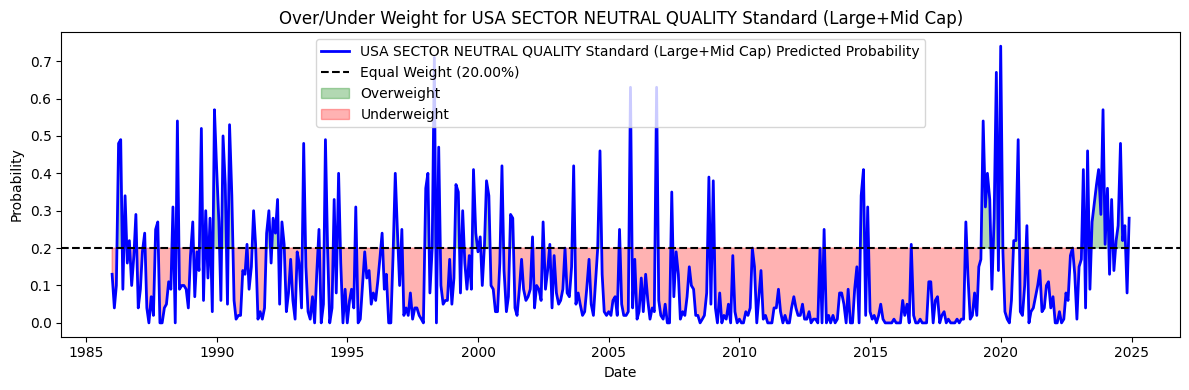

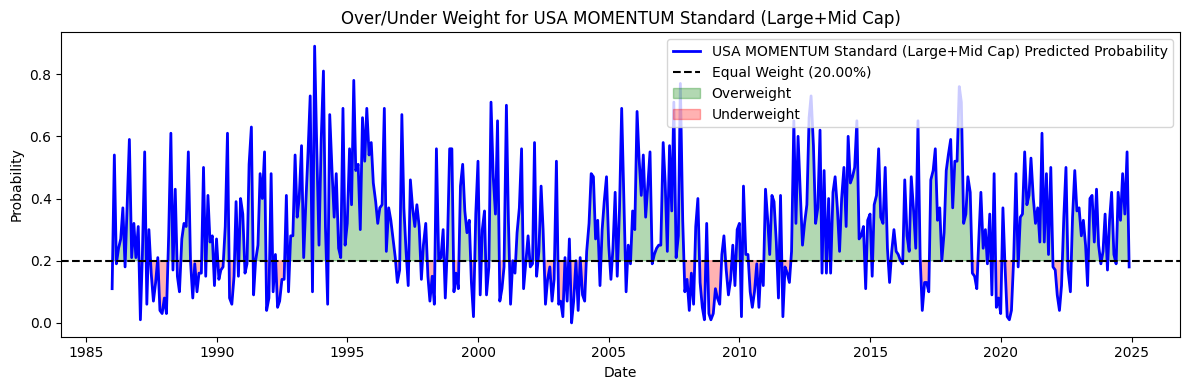

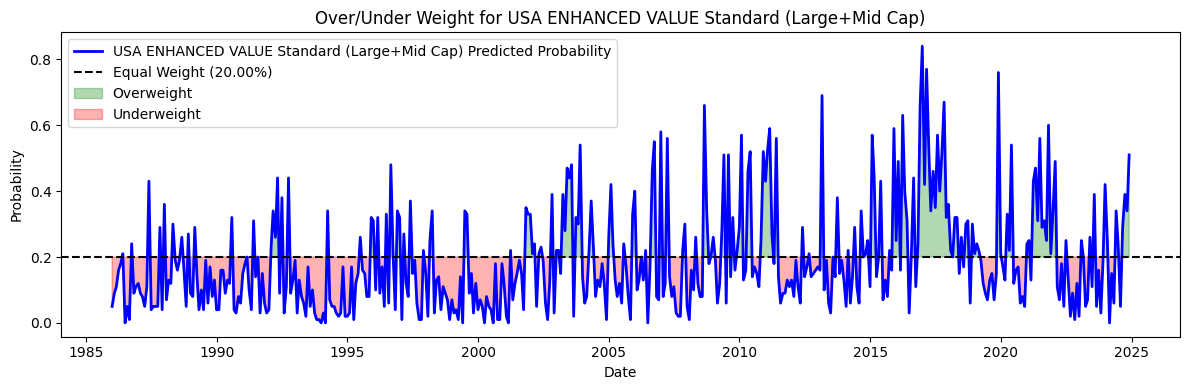

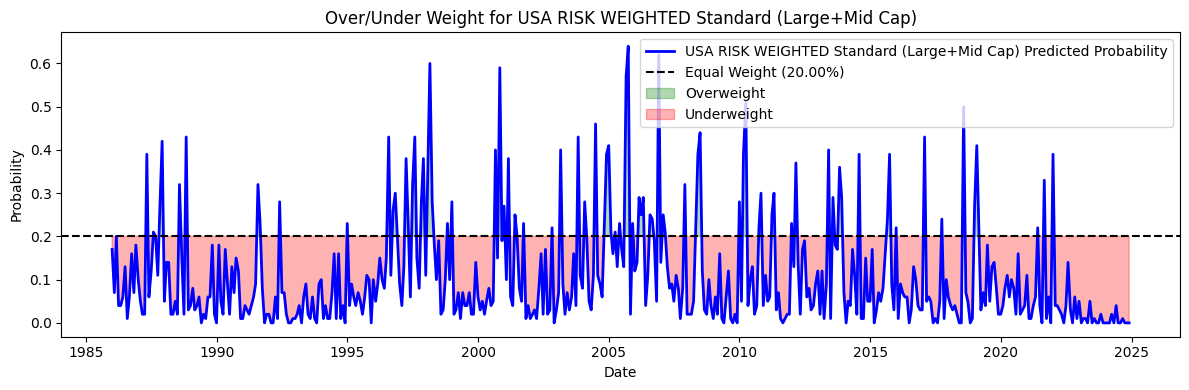

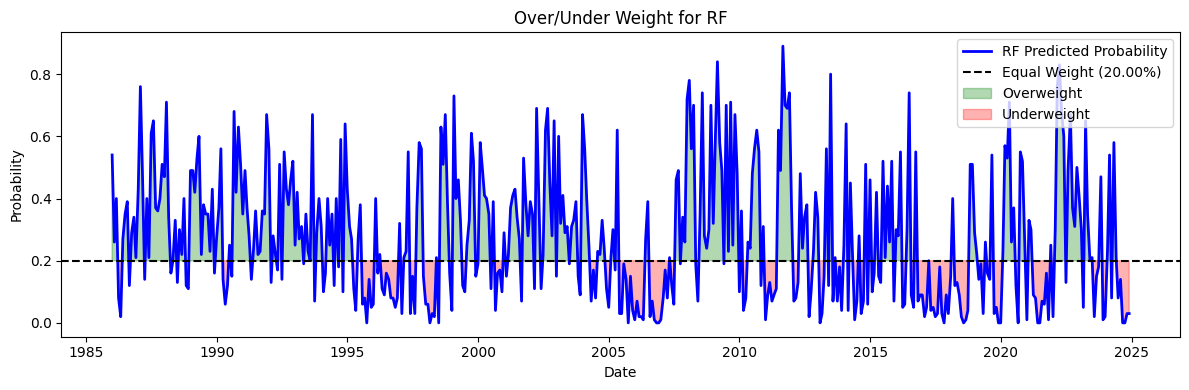

In [183]:
# --- Extra Code Cell: Over/Under Weight Comparison for Each Factor ---

# Define the equal weight value (static equal weight for each factor)
equal_weight = 1 / len(FACTORS)  # For example, if 5 factors then equal_weight = 0.20

import matplotlib.pyplot as plt

# Loop over each factor in FACTORS and create a separate chart
for factor in FACTORS:
    plt.figure(figsize=(12, 4))

    # Plot the predicted probability for the current factor
    plt.plot(probability_df["Date"], probability_df[factor],
             label=f"{factor} Predicted Probability", color='blue', linewidth=2)

    # Plot the static equal weight line
    plt.axhline(equal_weight, color='black', linestyle='--',
                label=f"Equal Weight ({equal_weight:.2%})")

    # Shade the area where the predicted probability is above the equal weight (Overweight)
    plt.fill_between(probability_df["Date"],
                     probability_df[factor],
                     equal_weight,
                     where=(probability_df[factor] > equal_weight),
                     interpolate=True, color='green', alpha=0.3, label='Overweight')

    # Shade the area where the predicted probability is below the equal weight (Underweight)
    plt.fill_between(probability_df["Date"],
                     probability_df[factor],
                     equal_weight,
                     where=(probability_df[factor] < equal_weight),
                     interpolate=True, color='red', alpha=0.3, label='Underweight')

    # Set chart title and labels
    plt.title(f"Over/Under Weight for {factor}")
    plt.xlabel("Date")
    plt.ylabel("Probability")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [184]:
# --- Extra Code Cell: Separate Attribution Analysis Charts for Each Factor ---

# Merge the predicted probabilities with factor returns.
# We use suffixes to distinguish between probability and return columns.
attribution_df = pd.merge(
    probability_df,
    merged_df,
    left_on="Date",
    right_on="Predicted_month",
    suffixes=('_prob', '_return')
)

# Define the static equal weight (1 divided by the number of factors)
equal_weight = 1 / len(FACTORS)  # e.g., if 5 factors, equal_weight = 0.20

# Loop over each factor to compute its excess contribution and generate a chart.
for factor in FACTORS:
    # Calculate the excess contribution for this factor:
    # (predicted probability - equal weight) * factor return.
    attribution_df[f'{factor}_excess'] = (attribution_df[f'{factor}_prob'] - equal_weight) * attribution_df[f'{factor}_return']

    # Plot the excess contribution over time.
    plt.figure(figsize=(12, 4))
    plt.plot(attribution_df['Date'], attribution_df[f'{factor}_excess'], label=f'{factor} Excess Contribution', color='blue', linewidth=2)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Baseline for zero excess
    plt.xlabel("Date")
    plt.ylabel("Excess Return Contribution")
    plt.title(f"Attribution Analysis for {factor}")
    plt.legend(loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

KeyError: 'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)_prob'

In [185]:
# --- Extra Code Cell: Combined Attribution Analysis Chart (3x Bigger) ---
# Merge the predicted probabilities (from probability_df) with factor returns (from merged_df)
attribution_df = pd.merge(
    probability_df,
    merged_df,
    left_on="Date",
    right_on="Predicted_month",
    suffixes=('_prob', '_return')
)

# Define the static equal weight (1 divided by the number of factors)
equal_weight = 1 / len(FACTORS)  # For example, if 5 factors then equal_weight = 0.20

# Calculate each factor's excess contribution
for factor in FACTORS: attribution_df[f'{factor}_excess'] = (attribution_df[f'{factor}_prob'] - equal_weight) * attribution_df[f'{factor}_return']

# Compute the total excess return as the sum of individual factor contributions.
excess_cols = [f'{factor}_excess' for factor in FACTORS]
attribution_df['total_excess'] = attribution_df[excess_cols].sum(axis=1)

# Create a combined chart: a stacked area chart for each factor's contribution with an overlay for total excess return.
plt.figure(figsize=(36, 18))  # 3x bigger than the original 12x6 size
dates = attribution_df["Date"]

# Prepare the data for stacking: a list of each factor's excess contribution over time.
stack_data = [attribution_df[f'{factor}_excess'].values for factor in FACTORS]

# Plot the stacked area chart.
plt.stackplot(dates, *stack_data, labels=FACTORS, alpha=0.8)

# Overlay a line for the total excess return.
plt.plot(dates, attribution_df['total_excess'], color='black', linewidth=3, label='Total Excess Return')

plt.xlabel("Date", fontsize=20)
plt.ylabel("Excess Return Contribution", fontsize=20)
plt.title("Combined Attribution Analysis: ML Strategy Excess Return vs Equal Weight", fontsize=24)
plt.legend(loc='upper left', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

KeyError: 'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)_prob'

In [186]:
# --- Extra Code Cell: Combined ML Strategy Excess Return (Blue Line Chart) ---

# Merge the predicted probabilities (from probability_df) with factor returns (from merged_df)
attribution_df = pd.merge(
    probability_df,
    merged_df,
    left_on="Date",
    right_on="Predicted_month",
    suffixes=('_prob', '_return')
)

# Define the static equal weight (1 divided by the number of factors)
equal_weight = 1 / len(FACTORS)  # e.g., for 5 factors, equal_weight = 0.20

# Compute each factor's excess contribution and then sum them to get the total excess return
excess_cols = []
for factor in FACTORS:
    col_name = f'{factor}_excess'
    attribution_df[col_name] = (attribution_df[f'{factor}_prob'] - equal_weight) * attribution_df[f'{factor}_return']
    excess_cols.append(col_name)

attribution_df['total_excess'] = attribution_df[excess_cols].sum(axis=1)

# Plot the total excess return as a blue line chart
plt.figure(figsize=(36, 18))  # 3x bigger than original (36x18 inches)
plt.plot(attribution_df["Date"], attribution_df['total_excess'], color='blue', linewidth=3, label='ML Excess Return')
plt.axhline(0, color='black', linestyle='--', linewidth=2, label='Equal Weight Baseline')

plt.xlabel("Date", fontsize=20)
plt.ylabel("Excess Return", fontsize=20)
plt.title("ML Strategy Excess Return vs Static Equal Weight", fontsize=24)
plt.legend(loc='upper left', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

KeyError: 'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)_prob'

In [187]:

import pandas as pd

# Assume probability_df is your DataFrame with a Date column and the factor probability columns:
# For example, columns: 'Date', 'SMB', 'HML', 'RMW', 'CMA'

# Compute the average probability for each factor over all time.
avg_probs = probability_df[['USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)', 'USA ENHANCED VALUE Standard (Large+Mid Cap)', 'USA RISK WEIGHTED Standard (Large+Mid Cap)', 'USA MOMENTUM Standard (Large+Mid Cap)', 'RF']].mean()

# Convert the Series to a DataFrame for clearer display:
avg_probs_df = avg_probs.reset_index()
avg_probs_df.columns = ['Factor', 'Average Probability']

print("Average Outperforming Probabilities Over Time:")
print(avg_probs_df)


Average Outperforming Probabilities Over Time:
                                              Factor  Average Probability
0  USA SECTOR NEUTRAL QUALITY Standard (Large+Mid...             0.123483
1        USA ENHANCED VALUE Standard (Large+Mid Cap)             0.189658
2         USA RISK WEIGHTED Standard (Large+Mid Cap)             0.107500
3              USA MOMENTUM Standard (Large+Mid Cap)             0.301218
4                                                 RF             0.278141


### **Backtesting & statistics**

In [188]:
# Ensure the 'Predicted_month' column is in datetime format
results_df['Predicted_month'] = pd.to_datetime(results_df['Predicted_month'])

# Get the earliest date from the 'Predicted_month' column
first_date = results_df['Predicted_month'].min()
last_date = results_df['Predicted_month'].max()

print("First date Predicted_month column in results_df:", first_date)
print("Last date in Predicted_month column results_df:", last_date)

First date Predicted_month column in results_df: 1985-12-31 00:00:00
Last date in Predicted_month column results_df: 2024-11-29 00:00:00


In [192]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Part 1: Process results_df ---

# Ensure 'Predicted_month' is in datetime format
results_df['Predicted_month'] = pd.to_datetime(results_df['Predicted_month'])

# Define your dynamic date range (adjust as needed)
start_date = pd.to_datetime('1985-12-31')
end_date   = pd.to_datetime('2024-11-29')

# Filter results_df for the date range and select the desired columns
filtered_df = results_df.loc[
    (results_df['Predicted_month'] >= start_date) & (results_df['Predicted_month'] <= end_date),
    ['Predicted_month', 'Allocated_Return']
].sort_values('Predicted_month')

# Rename 'Allocated_Return' to 'ML Allocated Strategy Return'
filtered_df = filtered_df.rename(columns={'Allocated_Return': 'ML Allocated Strategy Return'})

# Calculate cumulative returns for the ML allocated strategy using compound returns (wealth index starting at 1)
filtered_df['ML Cumulative Allocated Return'] = (1 + filtered_df['ML Allocated Strategy Return']).cumprod()


# --- Part 2: Process the second DataFrame (df) without modifying it ---

# Create a filtered copy of df for the same date range using the 'Date' column.
df_filtered = df.loc[
    (pd.to_datetime(df['Date']) >= start_date) & (pd.to_datetime(df['Date']) <= end_date)
].copy()

# Ensure the 'Date' column is datetime for correct sorting and merging
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# Sort by 'Date'
df_filtered = df_filtered.sort_values('Date')

# Calculate cumulative returns for the benchmark column using 'Mkt-Rf'
df_filtered['Benchmark Cumulative Returns'] = (1 + df_filtered['USA Standard (Large+Mid Cap)']).cumprod()

# Calculate the Equal Factor Weight Strategy returns by taking an equal-weight average of 4 factors (excluding MOM)
# Calculate the Equal Factor Weight Strategy returns by taking an equal-weight average of 4 factors (excluding MOMENTUM)
df_filtered['Equal Factor Weight Strategy'] = (
    df_filtered['USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)'] +
    df_filtered['USA ENHANCED VALUE Standard (Large+Mid Cap)'] +
    df_filtered['USA RISK WEIGHTED Standard (Large+Mid Cap)'] +
    df_filtered['USA MOMENTUM Standard (Large+Mid Cap)']
) / 4


# Calculate cumulative returns for the Equal Factor Weight Strategy using compound returns (wealth index starting at 1)
df_filtered['Equal Factor Weight Cumulative Return'] = (1 + df_filtered['Equal Factor Weight Strategy']).cumprod()


# --- Part 3: Merge the two DataFrames ---

# Merge the filtered DataFrames on their date columns:
#   - In filtered_df: 'Predicted_month' (as datetime)
#   - In df_filtered: 'Date'
merged_df = pd.merge(
    filtered_df,
    df_filtered[['Date', 'Benchmark Cumulative Returns', 'Equal Factor Weight Strategy', 'Equal Factor Weight Cumulative Return']],
    left_on='Predicted_month',
    right_on='Date',
    how='left'
)

# Drop the duplicate 'Date' column from the merge
merged_df.drop(columns=['Date'], inplace=True)

# Display the final merged DataFrame
print(merged_df)

    Predicted_month  ML Allocated Strategy Return  \
0        1985-12-31                      0.024464   
1        1986-01-31                      0.013907   
2        1986-02-28                      0.049891   
3        1986-03-31                      0.068504   
4        1986-04-30                     -0.015885   
..              ...                           ...   
463      2024-07-31                     -0.001346   
464      2024-08-30                      0.021608   
465      2024-09-30                      0.019365   
466      2024-10-31                     -0.007932   
467      2024-11-29                      0.053694   

     ML Cumulative Allocated Return  Benchmark Cumulative Returns  \
0                          1.024464                      1.048282   
1                          1.038712                      1.051546   
2                          1.090534                      1.127853   
3                          1.165240                      1.187398   
4                 

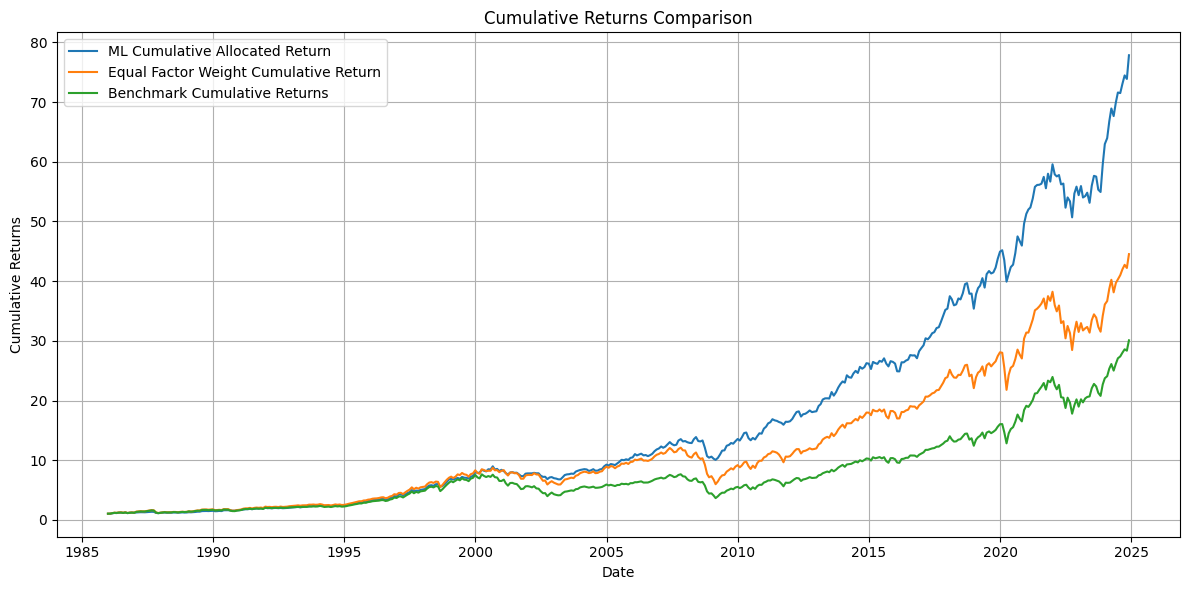

In [193]:
import matplotlib.pyplot as plt

# Ensure the DataFrame is sorted by Predicted_month
merged_df = merged_df.sort_values('Predicted_month')

plt.figure(figsize=(12, 6))

# Plot the ML Cumulative Allocated Return
plt.plot(
    merged_df['Predicted_month'],
    merged_df['ML Cumulative Allocated Return'],
    label='ML Cumulative Allocated Return'
)

# Plot the Equal Factor Weight Cumulative Return
plt.plot(
    merged_df['Predicted_month'],
    merged_df['Equal Factor Weight Cumulative Return'],
    label='Equal Factor Weight Cumulative Return'
)

# Plot the Benchmark Cumulative Returns
plt.plot(
    merged_df['Predicted_month'],
    merged_df['Benchmark Cumulative Returns'],
    label='Benchmark Cumulative Returns'
)

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [194]:
import numpy as np
import pandas as pd

# --- PERFORMANCE METRICS ---

# For the ML Allocated Strategy:
ml_returns = merged_df['ML Allocated Strategy Return']
ml_mean_monthly = ml_returns.mean()
ml_std_monthly  = ml_returns.std()
ml_annualized_return = ml_mean_monthly * 12
ml_annualized_vol    = ml_std_monthly * np.sqrt(12)
ml_sharpe            = ml_annualized_return / ml_annualized_vol

# For the Equal Factor Weight Strategy:
equal_returns = merged_df['Equal Factor Weight Strategy']
equal_mean_monthly = equal_returns.mean()
equal_std_monthly  = equal_returns.std()
equal_annualized_return = equal_mean_monthly * 12
equal_annualized_vol    = equal_std_monthly * np.sqrt(12)
equal_sharpe            = equal_annualized_return / equal_annualized_vol

# For the Benchmark Strategy:
# Calculate monthly returns from the benchmark cumulative returns.
benchmark_returns = merged_df['Benchmark Cumulative Returns'].pct_change()
benchmark_mean_monthly = benchmark_returns.mean()
benchmark_std_monthly = benchmark_returns.std()
benchmark_annualized_return = benchmark_mean_monthly * 12
benchmark_annualized_vol = benchmark_std_monthly * np.sqrt(12)
benchmark_sharpe = benchmark_annualized_return / benchmark_annualized_vol

# --- PRINT PERFORMANCE METRICS ---
print("\nPERFORMANCE METRICS:\n")

print("ML Allocated Strategy:")
print(f"  Annualized Return:      {ml_annualized_return:.2%}")
print(f"  Annualized Volatility:  {ml_annualized_vol:.2%}")
print(f"  Sharpe Ratio:           {ml_sharpe:.2f}\n")

print("Equal Factor Weight Strategy:")
print(f"  Annualized Return:      {equal_annualized_return:.2%}")
print(f"  Annualized Volatility:  {equal_annualized_vol:.2%}")
print(f"  Sharpe Ratio:           {equal_sharpe:.2f}\n")

print("Benchmark Strategy:")
print(f"  Annualized Return:      {benchmark_annualized_return:.2%}")
print(f"  Annualized Volatility:  {benchmark_annualized_vol:.2%}")
print(f"  Sharpe Ratio:           {benchmark_sharpe:.2f}\n")

# --- MAXIMUM DRAWDOWN CALCULATIONS ---
# Compute wealth indexes starting at 1 for each strategy.
wealth_ml = (1 + merged_df['ML Allocated Strategy Return']).cumprod()
wealth_equal = (1 + merged_df['Equal Factor Weight Strategy']).cumprod()
# Benchmark cumulative returns are already computed, so we use that directly.
wealth_benchmark = merged_df['Benchmark Cumulative Returns']

# Compute drawdown series for each strategy:
drawdown_ml = wealth_ml / wealth_ml.cummax() - 1
drawdown_equal = wealth_equal / wealth_equal.cummax() - 1
drawdown_benchmark = wealth_benchmark / wealth_benchmark.cummax() - 1

# Maximum drawdown is the minimum value in the drawdown series.
max_dd_ml = drawdown_ml.min()
max_dd_equal = drawdown_equal.min()
max_dd_benchmark = drawdown_benchmark.min()

print("MAXIMUM DRAWDOWNS:\n")
print("ML Allocated Strategy Max Drawdown:       ", f"{max_dd_ml:.2%}")
print("Equal Factor Weight Strategy Max Drawdown:  ", f"{max_dd_equal:.2%}")
print("Benchmark Max Drawdown:                     ", f"{max_dd_benchmark:.2%}")



PERFORMANCE METRICS:

ML Allocated Strategy:
  Annualized Return:      11.77%
  Annualized Volatility:  10.55%
  Sharpe Ratio:           1.12

Equal Factor Weight Strategy:
  Annualized Return:      10.92%
  Annualized Volatility:  15.01%
  Sharpe Ratio:           0.73

Benchmark Strategy:
  Annualized Return:      9.85%
  Annualized Volatility:  15.36%
  Sharpe Ratio:           0.64

MAXIMUM DRAWDOWNS:

ML Allocated Strategy Max Drawdown:        -27.56%
Equal Factor Weight Strategy Max Drawdown:   -50.55%
Benchmark Max Drawdown:                      -52.22%


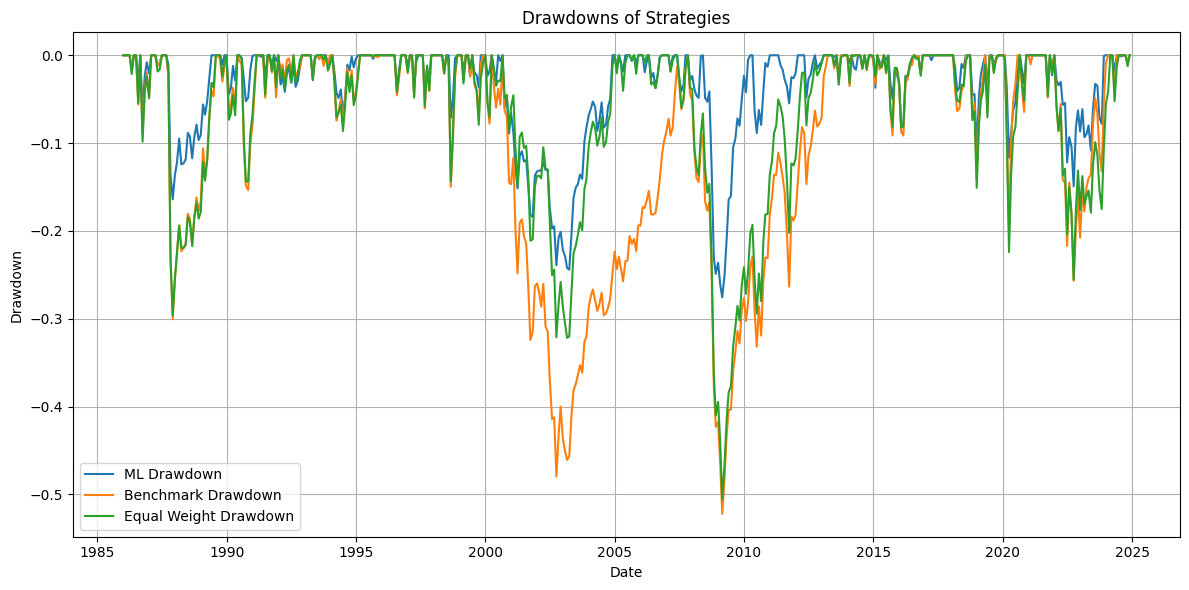

In [195]:
import matplotlib.pyplot as plt

# --- Compute Drawdowns for Each Strategy ---

# ML Allocated Strategy Drawdown
merged_df['ML Drawdown'] = merged_df['ML Cumulative Allocated Return'] / merged_df['ML Cumulative Allocated Return'].cummax() - 1

# Benchmark Drawdown
merged_df['Benchmark Drawdown'] = merged_df['Benchmark Cumulative Returns'] / merged_df['Benchmark Cumulative Returns'].cummax() - 1

# Equal Factor Weight Strategy Drawdown
merged_df['Equal Weight Drawdown'] = merged_df['Equal Factor Weight Cumulative Return'] / merged_df['Equal Factor Weight Cumulative Return'].cummax() - 1

# --- Plot the Drawdowns ---
plt.figure(figsize=(12, 6))

plt.plot(merged_df['Predicted_month'], merged_df['ML Drawdown'], label='ML Drawdown')
plt.plot(merged_df['Predicted_month'], merged_df['Benchmark Drawdown'], label='Benchmark Drawdown')
plt.plot(merged_df['Predicted_month'], merged_df['Equal Weight Drawdown'], label='Equal Weight Drawdown')

plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.title('Drawdowns of Strategies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [196]:
import statsmodels.api as sm
import pandas as pd

# --- Step 0: Verify Required Columns in df ---
# Added "MOM" to the required columns list.
required_cols = ['Date', 'SMB', 'HML', 'RMW', 'CMA', 'Mkt-RF', 'MOM']
missing = [col for col in required_cols if col not in df.columns]
if missing:
    raise KeyError(f"Missing columns in df: {missing}")

# --- Step 1: Merge the Additional Factor Columns into merged_df ---
# merged_df should already have 'Predicted_month' as datetime.
merged_df = merged_df.merge(
    df[required_cols],
    left_on='Predicted_month',
    right_on='Date',
    how='left',
    suffixes=('', '_new')  # in case some columns already exist in merged_df
)

# For each factor column, if a duplicate appears (with suffix '_new'), use it.
for col in ['SMB', 'HML', 'RMW', 'CMA', 'Mkt-RF', 'MOM']:
    new_col = col + '_new'
    if new_col in merged_df.columns:
        merged_df[col] = merged_df[new_col]
        merged_df.drop(columns=[new_col], inplace=True)

# Drop the duplicate 'Date' column from the merge.
merged_df.drop(columns=['Date'], inplace=True)

# --- Step 2: Multi-Factor Regression for the ML Allocated Strategy ---
# Include 'MOM' along with the other factors.
X_ml = merged_df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']]
X_ml = sm.add_constant(X_ml)  # Add the intercept term
y_ml = merged_df['ML Allocated Strategy Return']  # Dependent variable (excess returns)

# Run the multi-factor OLS regression for the ML strategy.
model_ml = sm.OLS(y_ml, X_ml).fit()

print("Regression Results: ML Allocated Strategy vs FF Factors (including MOM)")
print(model_ml.summary())

# --- Step 3: Multi-Factor Regression for the Equal Factor Weight Strategy ---
X_eq = merged_df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']]
X_eq = sm.add_constant(X_eq)
y_eq = merged_df['Equal Factor Weight Strategy']  # Dependent variable (excess returns)

model_eq = sm.OLS(y_eq, X_eq).fit()

print("\nRegression Results: Equal Factor Weight Strategy vs FF Factors (including MOM)")
print(model_eq.summary())

# --- Step 4: Annualize the Alpha and Report t-Statistic and p-Value ---
# For the ML Allocated Strategy:
alpha_ml = model_ml.params['const']            # monthly alpha
annualized_alpha_ml = alpha_ml * 12              # simple annualization
t_alpha_ml = model_ml.tvalues['const']
p_alpha_ml = model_ml.pvalues['const']

# For the Equal Factor Weight Strategy:
alpha_eq = model_eq.params['const']
annualized_alpha_eq = alpha_eq * 12
t_alpha_eq = model_eq.tvalues['const']
p_alpha_eq = model_eq.pvalues['const']

print("\nAnnualized Alpha Metrics:")
print("ML Allocated Strategy:")
print(f"  Annualized Alpha: {annualized_alpha_ml:.2%}")
print(f"  T-statistic:      {t_alpha_ml:.2f}")
print(f"  P-value:          {p_alpha_ml:.4f}")

print("\nEqual Factor Weight Strategy:")
print(f"  Annualized Alpha: {annualized_alpha_eq:.2%}")
print(f"  T-statistic:      {t_alpha_eq:.2f}")
print(f"  P-value:          {p_alpha_eq:.4f}")

Regression Results: ML Allocated Strategy vs FF Factors (including MOM)
                                 OLS Regression Results                                 
Dep. Variable:     ML Allocated Strategy Return   R-squared:                       0.846
Model:                                      OLS   Adj. R-squared:                  0.844
Method:                           Least Squares   F-statistic:                     421.8
Date:                          Sun, 09 Mar 2025   Prob (F-statistic):          1.16e-183
Time:                                  10:25:06   Log-Likelihood:                 1408.2
No. Observations:                           468   AIC:                            -2802.
Df Residuals:                               461   BIC:                            -2773.
Df Model:                                     6                                         
Covariance Type:                      nonrobust                                         
                 coef    std err      

In [197]:
import numpy as np
import pandas as pd

# Create a Year column from the 'Predicted_month'
merged_df['Year'] = merged_df['Predicted_month'].dt.year

def annual_sharpe(group, col):
    """
    Calculate the annual Sharpe ratio for a given return column within a group (year).
    Annual Return is computed as the product of (1 + monthly return) minus 1.
    Annual Volatility is computed as the standard deviation of monthly returns * sqrt(12).
    The Sharpe ratio is then annual return divided by annual volatility.
    """
    # Compound monthly returns to get the annual return:
    annual_return = (1 + group[col]).prod() - 1
    # Annualize the monthly volatility:
    annual_vol = group[col].std() * np.sqrt(12)
    # Compute Sharpe ratio (assume risk-free rate = 0)
    sharpe = annual_return / annual_vol if annual_vol != 0 else np.nan
    return sharpe

# Calculate annual Sharpe ratios for each strategy by grouping on 'Year'
sharpe_ml = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'ML Allocated Strategy Return'))
sharpe_bench = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'Mkt-RF'))
sharpe_equal = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'Equal Factor Weight Strategy'))

# Combine the Sharpe ratios into one DataFrame
annual_sharpe_table = pd.DataFrame({
    'ML Sharpe Ratio': sharpe_ml,
    'Benchmark Sharpe Ratio': sharpe_bench,
    'Equal Weight Sharpe Ratio': sharpe_equal
})

# Optionally format the table for clearer display (2 decimal places)
annual_sharpe_table = annual_sharpe_table.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)

print("Yearly Sharpe Ratios:")
print(annual_sharpe_table)

Yearly Sharpe Ratios:
     ML Sharpe Ratio Benchmark Sharpe Ratio Equal Weight Sharpe Ratio
Year                                                                 
1985             NaN                    NaN                       NaN
1986            1.30                   0.55                      0.91
1987           -0.15                  -0.12                     -0.01
1988            0.68                   1.09                      1.03
1989            2.83                   1.67                      2.45
1990            0.55                  -0.69                     -0.26
1991            2.78                   1.77                      2.03
1992            0.34                   0.79                      0.58
1993            2.18                   1.20                      1.49
1994            0.55                  -0.39                     -0.11
1995            6.95                   5.41                      7.64
1996            2.31                   1.38                      2.2

<ipython-input-197-e20a9db8b830>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sharpe_ml = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'ML Allocated Strategy Return'))
<ipython-input-197-e20a9db8b830>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sharpe_bench = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'Mkt-RF'))
<ipython-in

<ipython-input-198-bed794b1b2af>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_return_ml = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'ML Allocated Strategy Return'))
<ipython-input-198-bed794b1b2af>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_return_equal = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'Equal Factor Weight Strategy'))
<ipython-in

Annual Metrics:
     ML Annual Return Equal Annual Return Benchmark Annual Return  \
Year                                                                
1985             0.02                0.05                    0.00   
1986             0.18                0.17                    0.13   
1987            -0.02               -0.00                    0.01   
1988             0.05                0.10                    0.12   
1989             0.23                0.31                    0.27   
1990             0.07               -0.05                   -0.06   
1991             0.25                0.32                    0.27   
1992             0.02                0.05                    0.04   
1993             0.12                0.10                    0.07   
1994             0.05               -0.01                   -0.01   
1995             0.33                0.36                    0.35   
1996             0.22                0.23                    0.21   
1997             0

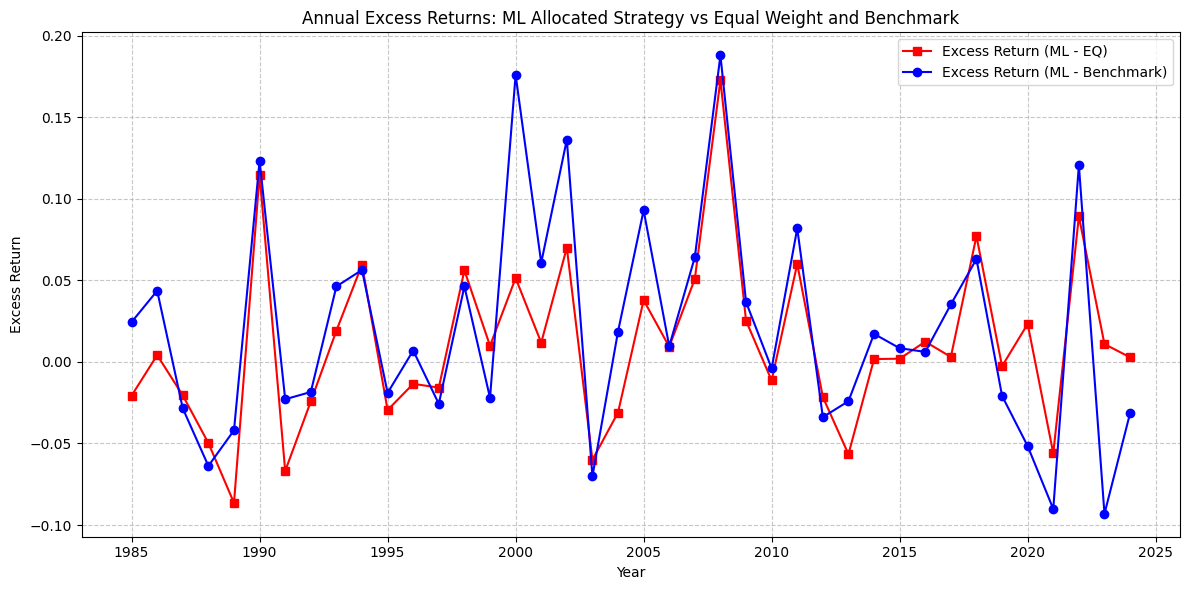

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Prepare the Data: Create a Year Column from 'Predicted_month' ---
merged_df['Year'] = merged_df['Predicted_month'].dt.year

# --- Create Benchmark Monthly Return Column ---
# Calculate monthly returns for the benchmark using the cumulative returns series.
merged_df['Benchmark Return'] = merged_df['Benchmark Cumulative Returns'].pct_change()

# --- Function to Calculate Annual Return ---
def annual_return(group, col):
    """
    Compute the annual return as the compounded return over the year.
    """
    return (1 + group[col]).prod() - 1

# --- Compute Annual Returns for Each Strategy by Grouping on 'Year' ---
annual_return_ml = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'ML Allocated Strategy Return'))
annual_return_equal = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'Equal Factor Weight Strategy'))
annual_return_benchmark = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'Benchmark Return'))

# --- Compute Excess Returns ---
excess_return_ml_eq = annual_return_ml - annual_return_equal
excess_return_ml_bench = annual_return_ml - annual_return_benchmark

# --- Combine into a DataFrame ---
annual_metrics = pd.DataFrame({
    'ML Annual Return': annual_return_ml,
    'Equal Annual Return': annual_return_equal,
    'Benchmark Annual Return': annual_return_benchmark,
    'Excess Return (ML - EQ)': excess_return_ml_eq,
    'Excess Return (ML - Benchmark)': excess_return_ml_bench
})

# --- Optionally Format the Metrics for Display ---
annual_metrics_formatted = annual_metrics.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)
print("Annual Metrics:")
print(annual_metrics_formatted)

# --- Plot the Excess Returns ---
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(annual_metrics.index, annual_metrics['Excess Return (ML - EQ)'],
        label='Excess Return (ML - EQ)', color='red', marker='s')
ax.plot(annual_metrics.index, annual_metrics['Excess Return (ML - Benchmark)'],
        label='Excess Return (ML - Benchmark)', color='blue', marker='o')
ax.set_xlabel('Year')
ax.set_ylabel('Excess Return')
ax.set_title('Annual Excess Returns: ML Allocated Strategy vs Equal Weight and Benchmark')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


<ipython-input-199-c057e9aa49d5>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_return_ml = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'ML Allocated Strategy Return'))
<ipython-input-199-c057e9aa49d5>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_returns_factors[factor] = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, factor))
<ipython-input-199-c057e

Annual Metrics:
      ML Annual Return  SMB Annual Return  Excess Return (ML - SMB)  \
Year                                                                  
1985            0.0245            -0.0041                    0.0286   
1986            0.1779            -0.0937                    0.2715   
1987           -0.0224            -0.0909                    0.0685   
1988            0.0526             0.0538                   -0.0012   
1989            0.2272            -0.1050                    0.3322   
1990            0.0675            -0.1428                    0.2103   
1991            0.2488             0.1248                    0.1240   
1992            0.0232             0.0807                   -0.0574   
1993            0.1165             0.0578                    0.0587   
1994            0.0479            -0.0255                    0.0734   
1995            0.3284            -0.0597                    0.3881   
1996            0.2206            -0.0243                    

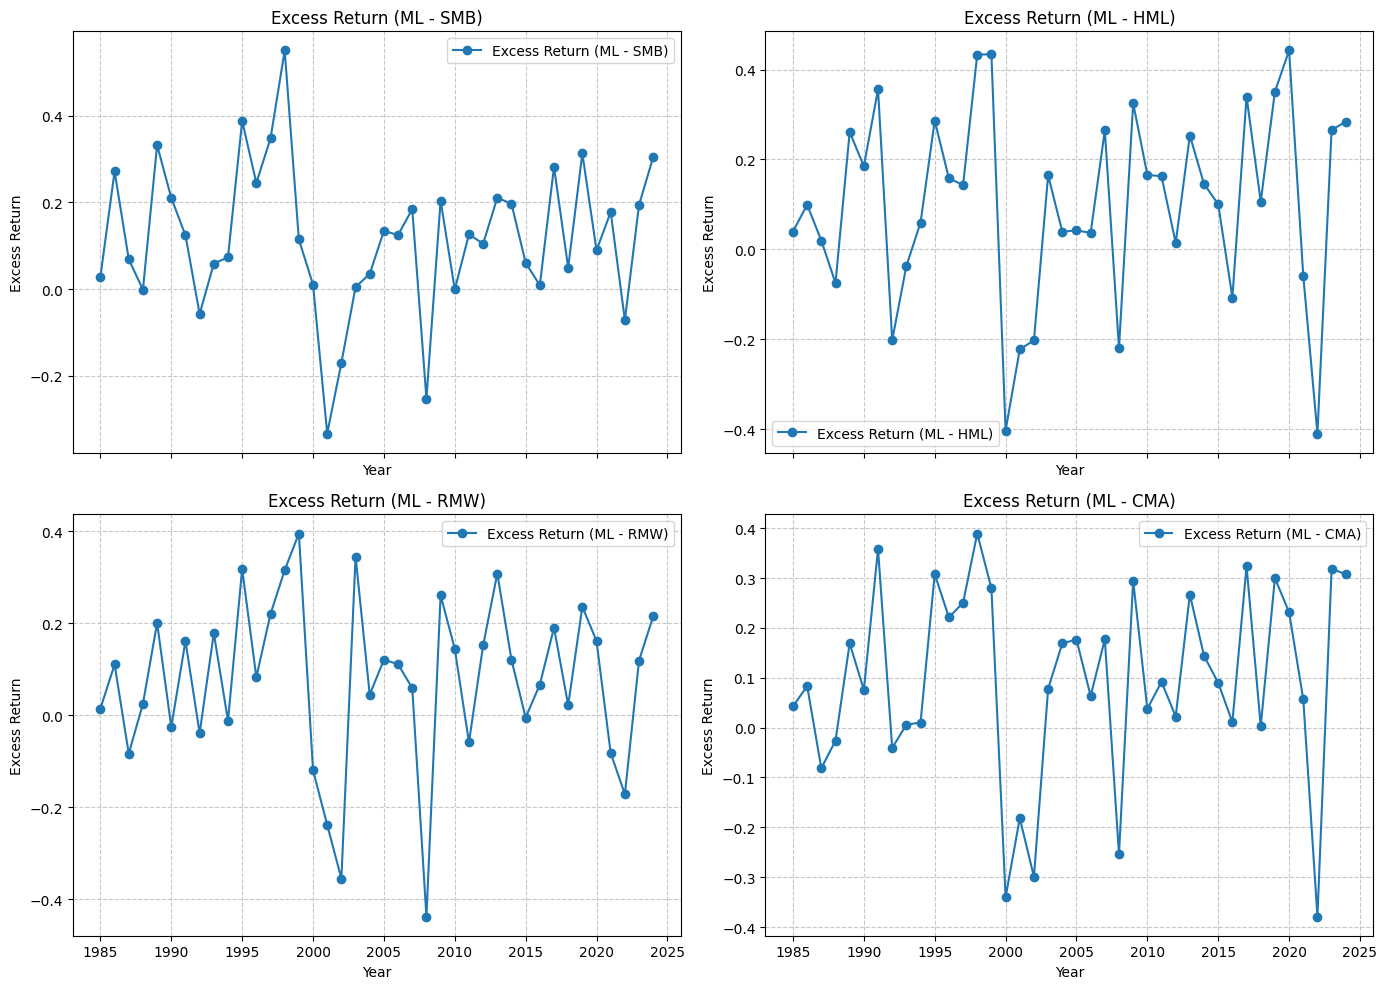

In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Prepare the Data: Create a Year Column from 'Predicted_month'
merged_df['Year'] = merged_df['Predicted_month'].dt.year

# --- Function to Calculate Annual Return ---
def annual_return(group, col):
    """
    Compute the annual return as the compounded return over the year.
    """
    return (1 + group[col]).prod() - 1

# --- Compute Annual Returns for the ML Allocated Strategy ---
annual_return_ml = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'ML Allocated Strategy Return'))

# --- Compute Annual Returns for Each Factor ---
factor_names = ['SMB', 'HML', 'RMW', 'CMA']
annual_returns_factors = {}
excess_returns = {}

for factor in factor_names:
    annual_returns_factors[factor] = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, factor))
    # Compute excess return: ML strategy annual return minus factor's annual return.
    excess_returns[factor] = annual_return_ml - annual_returns_factors[factor]

# Combine the computed metrics into a DataFrame for reference (optional)
annual_metrics = pd.DataFrame({'ML Annual Return': annual_return_ml})
for factor in factor_names:
    annual_metrics[f'{factor} Annual Return'] = annual_returns_factors[factor]
    annual_metrics[f'Excess Return (ML - {factor})'] = excess_returns[factor]

print("Annual Metrics:")
print(annual_metrics.round(4))

# --- Plot Excess Returns for Each Factor ---
fig, axes = plt.subplots(2, 2, figsize=(14,10), sharex=True)
axes = axes.flatten()

for idx, factor in enumerate(factor_names):
    ax = axes[idx]
    # Plot excess return: ML annual return minus factor annual return.
    ax.plot(excess_returns[factor].index, excess_returns[factor],
            label=f'Excess Return (ML - {factor})', marker='o')
    ax.set_title(f'Excess Return (ML - {factor})')
    ax.set_xlabel('Year')
    ax.set_ylabel('Excess Return')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

<ipython-input-200-da1d96678990>:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=4.0)


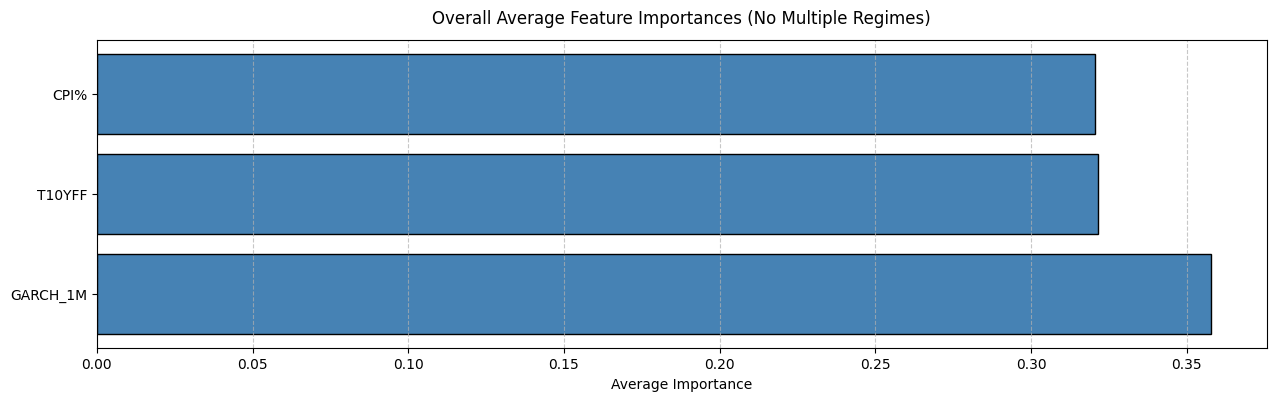

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======= USER-DEFINED DATE RANGE =======
# Adjust these dates to view feature importances for a specific period
start_date = pd.to_datetime('2007-01-31')
end_date   = pd.to_datetime('2009-12-31')

# ======= Filter the Data =======
# Filter the results_df for the specified date range based on the 'Predicted_month' column
filtered_results_df = results_df[
    (results_df['Predicted_month'] >= start_date) &
    (results_df['Predicted_month'] <= end_date)
]

# ======= Get Unique Regimes and Feature Count =======
existing_regimes = filtered_results_df['Regime'].unique()
n_regimes = len(existing_regimes)
n_features = len(filtered_results_df['Feature_Importances'].iloc[0])  # Assumes each entry is a vector

# ======= Robust Feature Naming =======
try:
    # Validate if the predefined FEATURES list matches the actual feature count
    if len(FEATURES) != n_features:
        print(f"⚠️ Warning: FEATURES list length ({len(FEATURES)}) doesn't match model features ({n_features}).")
        print("Using auto-generated feature names instead.")
        raise ValueError
    feature_names = FEATURES
except (NameError, ValueError):
    # Generate default feature names if there's a mismatch or if FEATURES is undefined
    feature_names = [f'Feature {i+1}' for i in range(n_features)]
    print(f"Using auto-generated feature names for {n_features} features.")

# ======= Compute Overall Average Feature Importances =======
overall_avg_fi = np.vstack(filtered_results_df['Feature_Importances'].values).mean(axis=0)

# ======= Compute Regime-Specific Average Feature Importances =======
regime_avg_fi = {}
for regime_name in existing_regimes:
    regime_df = filtered_results_df[filtered_results_df['Regime'] == regime_name]
    regime_fi_array = np.vstack(regime_df['Feature_Importances'].values)
    regime_avg_fi[regime_name] = regime_fi_array.mean(axis=0)

# ======= Sort Features by Overall Importance (Descending) =======
sorted_idx = overall_avg_fi.argsort()[::-1]
sorted_idx = sorted_idx[sorted_idx < len(feature_names)]  # Ensure index bounds
sorted_features = [feature_names[i] for i in sorted_idx]

# ======= Plotting =======
if n_regimes > 1:
    total_plots = 1 + n_regimes  # One overall plot plus one for each regime
    row_height = max(0.3 * n_features, 4)
    fig, axs = plt.subplots(
        total_plots,
        1,
        figsize=(19.5, total_plots * row_height),
        gridspec_kw={'hspace': 0.4}
    )
    if total_plots == 1:
        axs = [axs]

    # --- Overall Feature Importances ---
    axs[0].barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    axs[0].set_yticks(np.arange(n_features))
    axs[0].set_yticklabels(sorted_features)
    axs[0].set_title("Overall Average Feature Importances", pad=12)
    axs[0].set_xlabel("Average Importance")
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)

    # --- Regime-Specific Feature Importances ---
    for idx, (regime_name, avg_fi) in enumerate(regime_avg_fi.items(), start=1):
        sorted_regime_fi = avg_fi[sorted_idx]
        axs[idx].barh(
            np.arange(n_features),
            sorted_regime_fi,
            color='salmon',
            edgecolor='black'
        )
        axs[idx].set_yticks(np.arange(n_features))
        axs[idx].set_yticklabels(sorted_features)
        axs[idx].set_title(f"Feature Importances: {regime_name} Regime", pad=12)
        axs[idx].set_xlabel("Average Importance")
        axs[idx].grid(axis='x', linestyle='--', alpha=0.7)
else:
    # If zero or one regime, show only the overall chart
    row_height = max(0.3 * n_features, 4)
    fig, ax = plt.subplots(
        1, 1, figsize=(19.5, row_height),
        gridspec_kw={'hspace': 0.4}
    )
    ax.barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels(sorted_features)
    ax.set_title("Overall Average Feature Importances (No Multiple Regimes)", pad=12)
    ax.set_xlabel("Average Importance")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.3)  # Extra space for feature labels
plt.show()

In [202]:
import pandas as pd
import numpy as np

# ======================
# --- Part 1: Process results_df (ML Strategy) ---
# ======================

# Ensure 'Predicted_month' is in datetime format
results_df['Predicted_month'] = pd.to_datetime(results_df['Predicted_month'])

# Define your dynamic date range (adjust as needed)
start_date = pd.to_datetime('1973-08-01')
end_date   = pd.to_datetime('2025-01-01')

# Filter results_df for the date range and select the desired columns
filtered_df = results_df.loc[
    (results_df['Predicted_month'] >= start_date) & (results_df['Predicted_month'] <= end_date),
    ['Predicted_month', 'Allocated_Return']
].sort_values('Predicted_month')

# Rename 'Allocated_Return' to 'ML Allocated Strategy Return'
filtered_df = filtered_df.rename(columns={'Allocated_Return': 'ML Allocated Strategy Return'})

# Calculate cumulative returns for the ML allocated strategy using compound returns (wealth index starting at 1)
filtered_df['ML Cumulative Allocated Return'] = (1 + filtered_df['ML Allocated Strategy Return']).cumprod()


# ======================
# --- Part 2: Process the second DataFrame (df) (Benchmark, RMW & Equal Factor Weight) ---
# ======================

# Create a filtered copy of df for the same date range using the 'Date' column.
df_filtered = df.loc[
    (pd.to_datetime(df['Date']) >= start_date) & (pd.to_datetime(df['Date']) <= end_date)
].copy()

# Ensure the 'Date' column is datetime for correct sorting and merging
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# Sort by 'Date'
df_filtered = df_filtered.sort_values('Date')

# Calculate cumulative returns for the benchmark using 'USA Standard (Large+Mid Cap)'
df_filtered['Benchmark Cumulative Returns'] = (1 + df_filtered['USA Standard (Large+Mid Cap)']).cumprod()

# Calculate cumulative returns for the RMW benchmark using 'RMW'
df_filtered['RMW Cumulative'] = (1 + df_filtered['RMW']).cumprod()

# Calculate the Equal Factor Weight Strategy returns by taking an equal-weight average of 4 factors (excluding MOM)
df_filtered['Equal Factor Weight Strategy'] = (
    df_filtered['USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)'] +
    df_filtered['USA ENHANCED VALUE Standard (Large+Mid Cap)'] +
    df_filtered['USA RISK WEIGHTED Standard (Large+Mid Cap)'] +
    df_filtered['USA MOMENTUM Standard (Large+Mid Cap)']
) / 4

# Calculate cumulative returns for the Equal Factor Weight Strategy using compound returns (wealth index starting at 1)
df_filtered['Equal Factor Weight Cumulative Return'] = (1 + df_filtered['Equal Factor Weight Strategy']).cumprod()


# ======================
# --- Part 3: Merge the two DataFrames ---
# ======================

# Merge on the date columns:
merged_df = pd.merge(
    filtered_df,
    df_filtered[['Date', 'Benchmark Cumulative Returns', 'RMW Cumulative', 'Equal Factor Weight Strategy', 'Equal Factor Weight Cumulative Return']],
    left_on='Predicted_month',
    right_on='Date',
    how='left'
)

# Drop the duplicate 'Date' column from the merge
merged_df.drop(columns=['Date'], inplace=True)


# ======================
# --- Part 4: Define 5-Year Periods and Compute Cumulative Returns for Each Block ---
# ======================

def define_5_year_period(date, start_year=1973):
    """
    Assign each date to a discrete 5-year block starting at 'start_year'.
    For example, a date in 1973-1977 will be labeled "1973-1977",
    in 1978-1982 as "1978-1982", etc.
    """
    if pd.isnull(date):
        return None
    year = date.year
    block_index = (year - start_year) // 5
    block_start = start_year + 5 * block_index
    block_end = block_start + 4
    return f"{block_start}-{block_end}"

# Apply the function to create a new column for 5-year period labels
merged_df['5_Year_Period'] = merged_df['Predicted_month'].apply(lambda x: define_5_year_period(x, start_year=1973))

def five_year_return(group, col):
    """
    Compute the total return over the 5-year block for the given cumulative return column.
    This is done by taking the ratio of the last value to the first value of the block, minus 1.
    """
    group = group.sort_values(by='Predicted_month')
    start_val = group[col].iloc[0]
    end_val   = group[col].iloc[-1]
    return (end_val / start_val) - 1

# Group by the 5_Year_Period and compute returns for each strategy
five_year_results = merged_df.groupby('5_Year_Period').apply(
    lambda g: pd.Series({
        'ML_5yr_return'         : five_year_return(g, 'ML Cumulative Allocated Return'),
        'Equal_5yr_return'      : five_year_return(g, 'Equal Factor Weight Cumulative Return'),
        'Benchmark_5yr_return'  : five_year_return(g, 'Benchmark Cumulative Returns')
    })
).reset_index()

# Calculate the excess return of ML strategy over the Equal Factor Weight strategy (if desired)
five_year_results['Excess_return'] = five_year_results['ML_5yr_return'] - five_year_results['Equal_5yr_return']

# Calculate the difference between ML strategy and Benchmark
five_year_results['Diff ML vs Benchmark'] = five_year_results['ML_5yr_return'] - five_year_results['Benchmark_5yr_return']


# ======================
# --- Part 5: Display the 5-Year Cumulative Returns ---
# ======================

print("5-Year Cumulative Returns Comparison:")
print(five_year_results)

5-Year Cumulative Returns Comparison:
  5_Year_Period  ML_5yr_return  Equal_5yr_return  Benchmark_5yr_return  \
0     1983-1987       0.151492          0.171466              0.141059   
1     1988-1992       0.733730          0.830429              0.704279   
2     1993-1997       1.418087          1.341308              1.270773   
3     1998-2002       0.353603          0.117760             -0.122583   
4     2003-2007       0.908529          0.917837              0.730852   
5     2008-2012       0.398916          0.108011              0.043661   
6     2013-2017       0.854658          0.891037              0.776755   
7     2018-2022       0.451702          0.251990              0.354268   
8     2023-2027       0.391756          0.350737              0.488841   

   Excess_return  Diff ML vs Benchmark  
0      -0.019974              0.010432  
1      -0.096699              0.029452  
2       0.076779              0.147314  
3       0.235843              0.476187  
4      -0.009308

<ipython-input-202-31d9f0ddfb0b>:110: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  five_year_results = merged_df.groupby('5_Year_Period').apply(


# Corr Heat map & regiimi sharpet


In [ ]:
# # Plot Regime-wise Correlation Heatmaps
#
# For the selected return columns, compute and plot the correlation matrix
# for each market regime as a heatmap.

# %%
# Use the global FACTORS instead of redefining returns_columns
unique_regimes = df[REGIMES_COLUMN].unique()
for regime in unique_regimes:
    regime_data = df[df[REGIMES_COLUMN] == regime][FACTORS]
    corr = regime_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Return Correlation Heatmap - {regime}")
    plt.tight_layout()
    plt.show()



In [ ]:
# # Plot Sharpe Ratios by Market Regime
#
# Compute and visualize Sharpe ratios for selected factors across each regime,
# as well as the unconditional (all-data) values, using a bar chart.
# The numeric regime codes are converted back to their original names using the regime_mapping,
# and then further shortened using regime_short_mapping.

# %%
# Define factors and regime columns (using global variables if already defined)
factors_columns = df.columns[1:7]  # Adjust the column indices if needed
regimes_column = REGIMES_COLUMN   # Assumes REGIMES_COLUMN was defined earlier

# Use the previously created regime_short_mapping to convert numeric codes back to short names.
# (If a code is not in regime_short_mapping, it will default to "Regime <code>")
regime_short_names = {reg: regime_short_mapping.get(reg, f"Regime {reg}")
                      for reg in df[regimes_column].unique()}

# Calculate Sharpe ratios by regime using a dictionary comprehension and use the short names as keys.
sharpe_ratios = {
    regime_short_names[regime]: (
        df[df[regimes_column] == regime][factors_columns].mean() /
        df[df[regimes_column] == regime][factors_columns].std()
    )
    for regime in df[regimes_column].unique()
}

# Calculate the "Unconditional" Sharpe ratios (using all data)
sharpe_ratios["Unconditional"] = df[factors_columns].mean() / df[factors_columns].std()

# Convert the dictionary to a DataFrame and set column names
sharpe_ratios_df = pd.DataFrame(sharpe_ratios).T
sharpe_ratios_df.columns = factors_columns

# Plot the Sharpe ratios using the same styling as before.
plt.figure(figsize=(14, 8))
sharpe_ratios_df.plot(
    kind="bar",
    grid=True,
    colormap="viridis",
    title="Sharpe Ratios by Regime and Unconditional",
    figsize=(14, 8)
)
plt.ylabel("Sharpe Ratio", fontsize=12)
plt.xlabel("Market Regimes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Factors", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# --- Code cell: Export results to CSV ---

import pandas as pd

# 1) Merge the monthly ML strategy returns (from merged_df) into results_df
#    so that we have both "ML Allocated Strategy Return" and "Allocated_Return"
df_with_ml = pd.merge(
    results_df,
    merged_df[['Predicted_month', 'ML Allocated Strategy Return']],
    on='Predicted_month',
    how='left'
)

# 2) Merge the factor returns and benchmark from the original df
#    so that we have columns for each factor's monthly returns.
factor_columns = [
    'USA MOMENTUM Standard (Large+Mid Cap)',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)'
]
benchmark_col = 'USA Standard (Large+Mid Cap)'

df_with_factors = pd.merge(
    df_with_ml,
    df[['Date', benchmark_col] + factor_columns],
    left_on='Predicted_month',
    right_on='Date',
    how='left'
)

# 3) Identify the probability columns (those ending with '_prob', e.g. "Momentum_prob")
probability_columns = [col for col in df_with_factors.columns if col.endswith('_prob')]

# 4) Select and rename columns for clarity in the final CSV
#    Required columns (in order):
#       date
#       benchmark
#       return (ML strategy monthly return)
#       factor returns (one column per factor)
#       winning probabilities (one column per factor-prob)
#       allocated return (from the RF model)
columns_for_csv = [
    'Predicted_month',            # date
    benchmark_col,                # benchmark
    'ML Allocated Strategy Return',    # ML strategy's monthly return
] + factor_columns + probability_columns + [
    'Allocated_Return'            # allocated return from the classifier's probabilities
]

df_export = df_with_factors[columns_for_csv].copy()

# Rename the columns to match your exact specification
df_export = df_export.rename(columns={
    'Predicted_month': 'Date',
    benchmark_col:     'Benchmark_Return',
    'ML Allocated Strategy Return': 'ML_Strategy_Return',
    'Allocated_Return': 'Allocated_Return'
})

# 5) Export the DataFrame to CSV with ';' as the separator
output_filename = 'model_verification.csv'
df_export.to_csv(output_filename, sep=';', index=False)

print(f"CSV file '{output_filename}' has been created with the following columns:")
print(df_export.columns.tolist())
print("\nPreview:")
display(df_export.head(10))
